In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
from numpy.core.numeric import False_

from dashboard_app._format_utils import format_price_short, format_number_short, format_number, format_date, format_price, format_volume, format_percent, format_duration, format_event_datetime
from dashboard_app._chart_utils import chart_colors, get_chart_color

# Set global figure size and DPI
# Set figure size optimized for A4 (297mm x 210mm at 300dpi)
plt.rcParams['figure.figsize'] = (10, 7)  # Adjusted for better A4 fit
plt.rcParams['figure.dpi'] = 300

# Configure fonts
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 11  # Base font size
plt.rcParams['font.weight'] = 'normal'

# grid lines subtle thin
plt.rcParams['grid.color'] = '#d9d9d9'
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.linewidth'] = 0.5

# grid face light gray
# plt.rcParams['axes.facecolor'] = '#f9fafb'
plt.rcParams['axes.facecolor'] = '#FFFFFF'

# top and right spines off
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

# spines light gray thin
plt.rcParams['axes.edgecolor'] = '#d9d9d9'
plt.rcParams['axes.linewidth'] = 0.5


# Function to load data from CSV or DataFrame
def load_data(data_source):
	if isinstance(data_source, str):
		# Load data from CSV file
		data = pd.read_csv(f".//data/{data_source}")
	else:
		# Assume data_source is a DataFrame
		data = data_source
	return data


# Function to create subplots with consistent formatting
def create_subplots(nrows=1, ncols=1, figsize=(10, 6), sharex=False, sharey=False):
	fig, axes = plt.subplots(nrows, ncols, figsize=figsize, sharex=sharex, sharey=sharey)

	if nrows * ncols > 1:
		for ax in axes.flat:
			ax.tick_params(axis='both', which='major', labelsize=10)
			ax.tick_params(axis='both', which='minor', labelsize=8)
	else:
		axes.tick_params(axis='both', which='major', labelsize=10)
		axes.tick_params(axis='both', which='minor', labelsize=8)

	return fig, axes


# Function to format x-labels as event datetime
def format_xaxis_event_datetime(ax, include_time=True):
	ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: format_event_datetime(pd.to_datetime(x), include_time)))
	plt.xticks(rotation=45, ha='right')


# Function to add reference line to plot
def add_reference_line(ax, x=None, y=None, color='gray', linestyle='--', linewidth=1, label=None):
	if x is not None:
		ax.axvline(x, color=color, linestyle=linestyle, linewidth=linewidth, label=label)
	elif y is not None:
		ax.axhline(y, color=color, linestyle=linestyle, linewidth=linewidth, label=label)


def get_charts_dir(filename):
	return f"./{filename}"

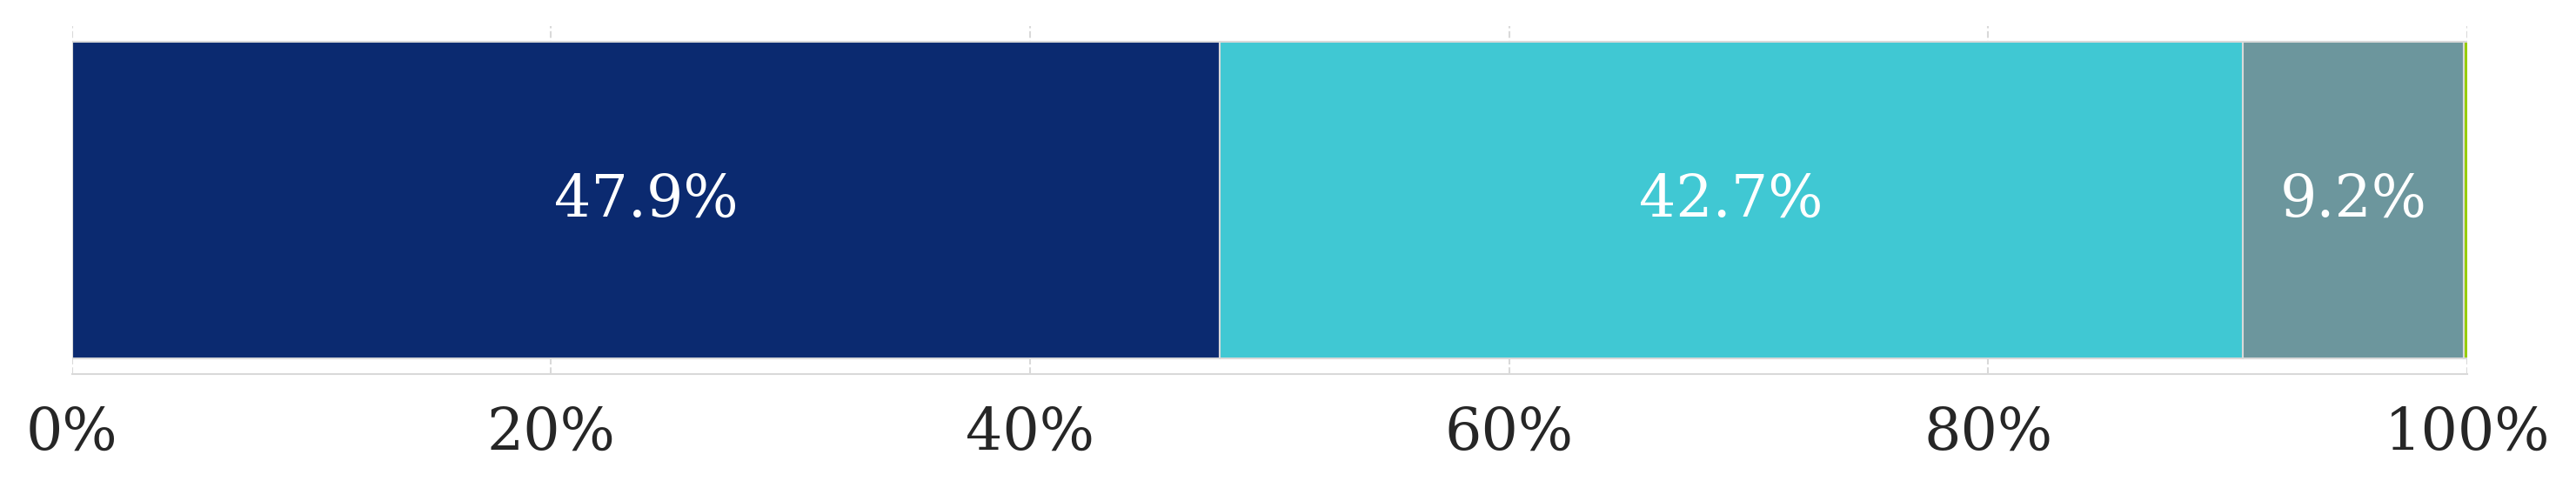

In [166]:
# Data from the pie chart
data = {
	"Payment Method": ["Card terminal", "Cash", "Online pre top-up", "VIP issued"],
	"Count": [8486, 7561, 1634, 23],
	"Total Value (CZK)": [7264503, 5782570, 1436400, 37500]
}

# Convert data to a DataFrame
df = pd.DataFrame(data)

# Calculate proportions for the 100% stacked bar chart
df["Proportion"] = df["Count"] / df["Count"].sum()

# Define a minimum proportion for visibility
min_proportion = 0.02  # Set minimum visual width (2%)
df["Visual Proportion"] = df["Proportion"].apply(lambda x: max(x, min_proportion))

# Prepare data for plotting
methods = df["Payment Method"]
proportions = df["Proportion"]
visual_proportions = df["Visual Proportion"]
total_values = df["Total Value (CZK)"]

# Create a subplot
fig, ax = create_subplots(figsize=(10, 2))  # Wider figure for a horizontal bar

# Plot the horizontal 100% stacked bar chart
left = 0
for i, (proportion, visual_proportion, method, value, color) in enumerate(
		zip(proportions, visual_proportions, methods, total_values, chart_colors[:len(methods)])
):
	ax.barh(
		y=0,
		width=visual_proportion,
		left=left,
		color=color,
		edgecolor="#d9d9d9",
		linewidth=0.5,
		label=method
	)
	# Add proportion and value label inside or outside based on size
	label_text = f"{proportion * 100:.1f}%"
	if visual_proportion < 0.03:  # If the segment is small, place the label outside
		continue
	else:
		ax.text(
			left + visual_proportion / 2,
			0,
			label_text,
			ha='center',
			va='center',
			color='white',
			fontsize=16,
		)
	left += visual_proportion

# Customize the axes
ax.set_xlim(0, 1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_yticks([])  # Remove y-ticks as it is a single bar
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{int(x * 100)}%"))
# x-ticks fontsize=16, pad=5
ax.tick_params(axis='x', which='major', labelsize=16, pad=5)
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4, fontsize=10, frameon=False)

plt.tight_layout()
# plt.show()
plt.savefig(get_charts_dir("rq2-topup-methods.png"), dpi=300, bbox_inches='tight', pad_inches=0.1)

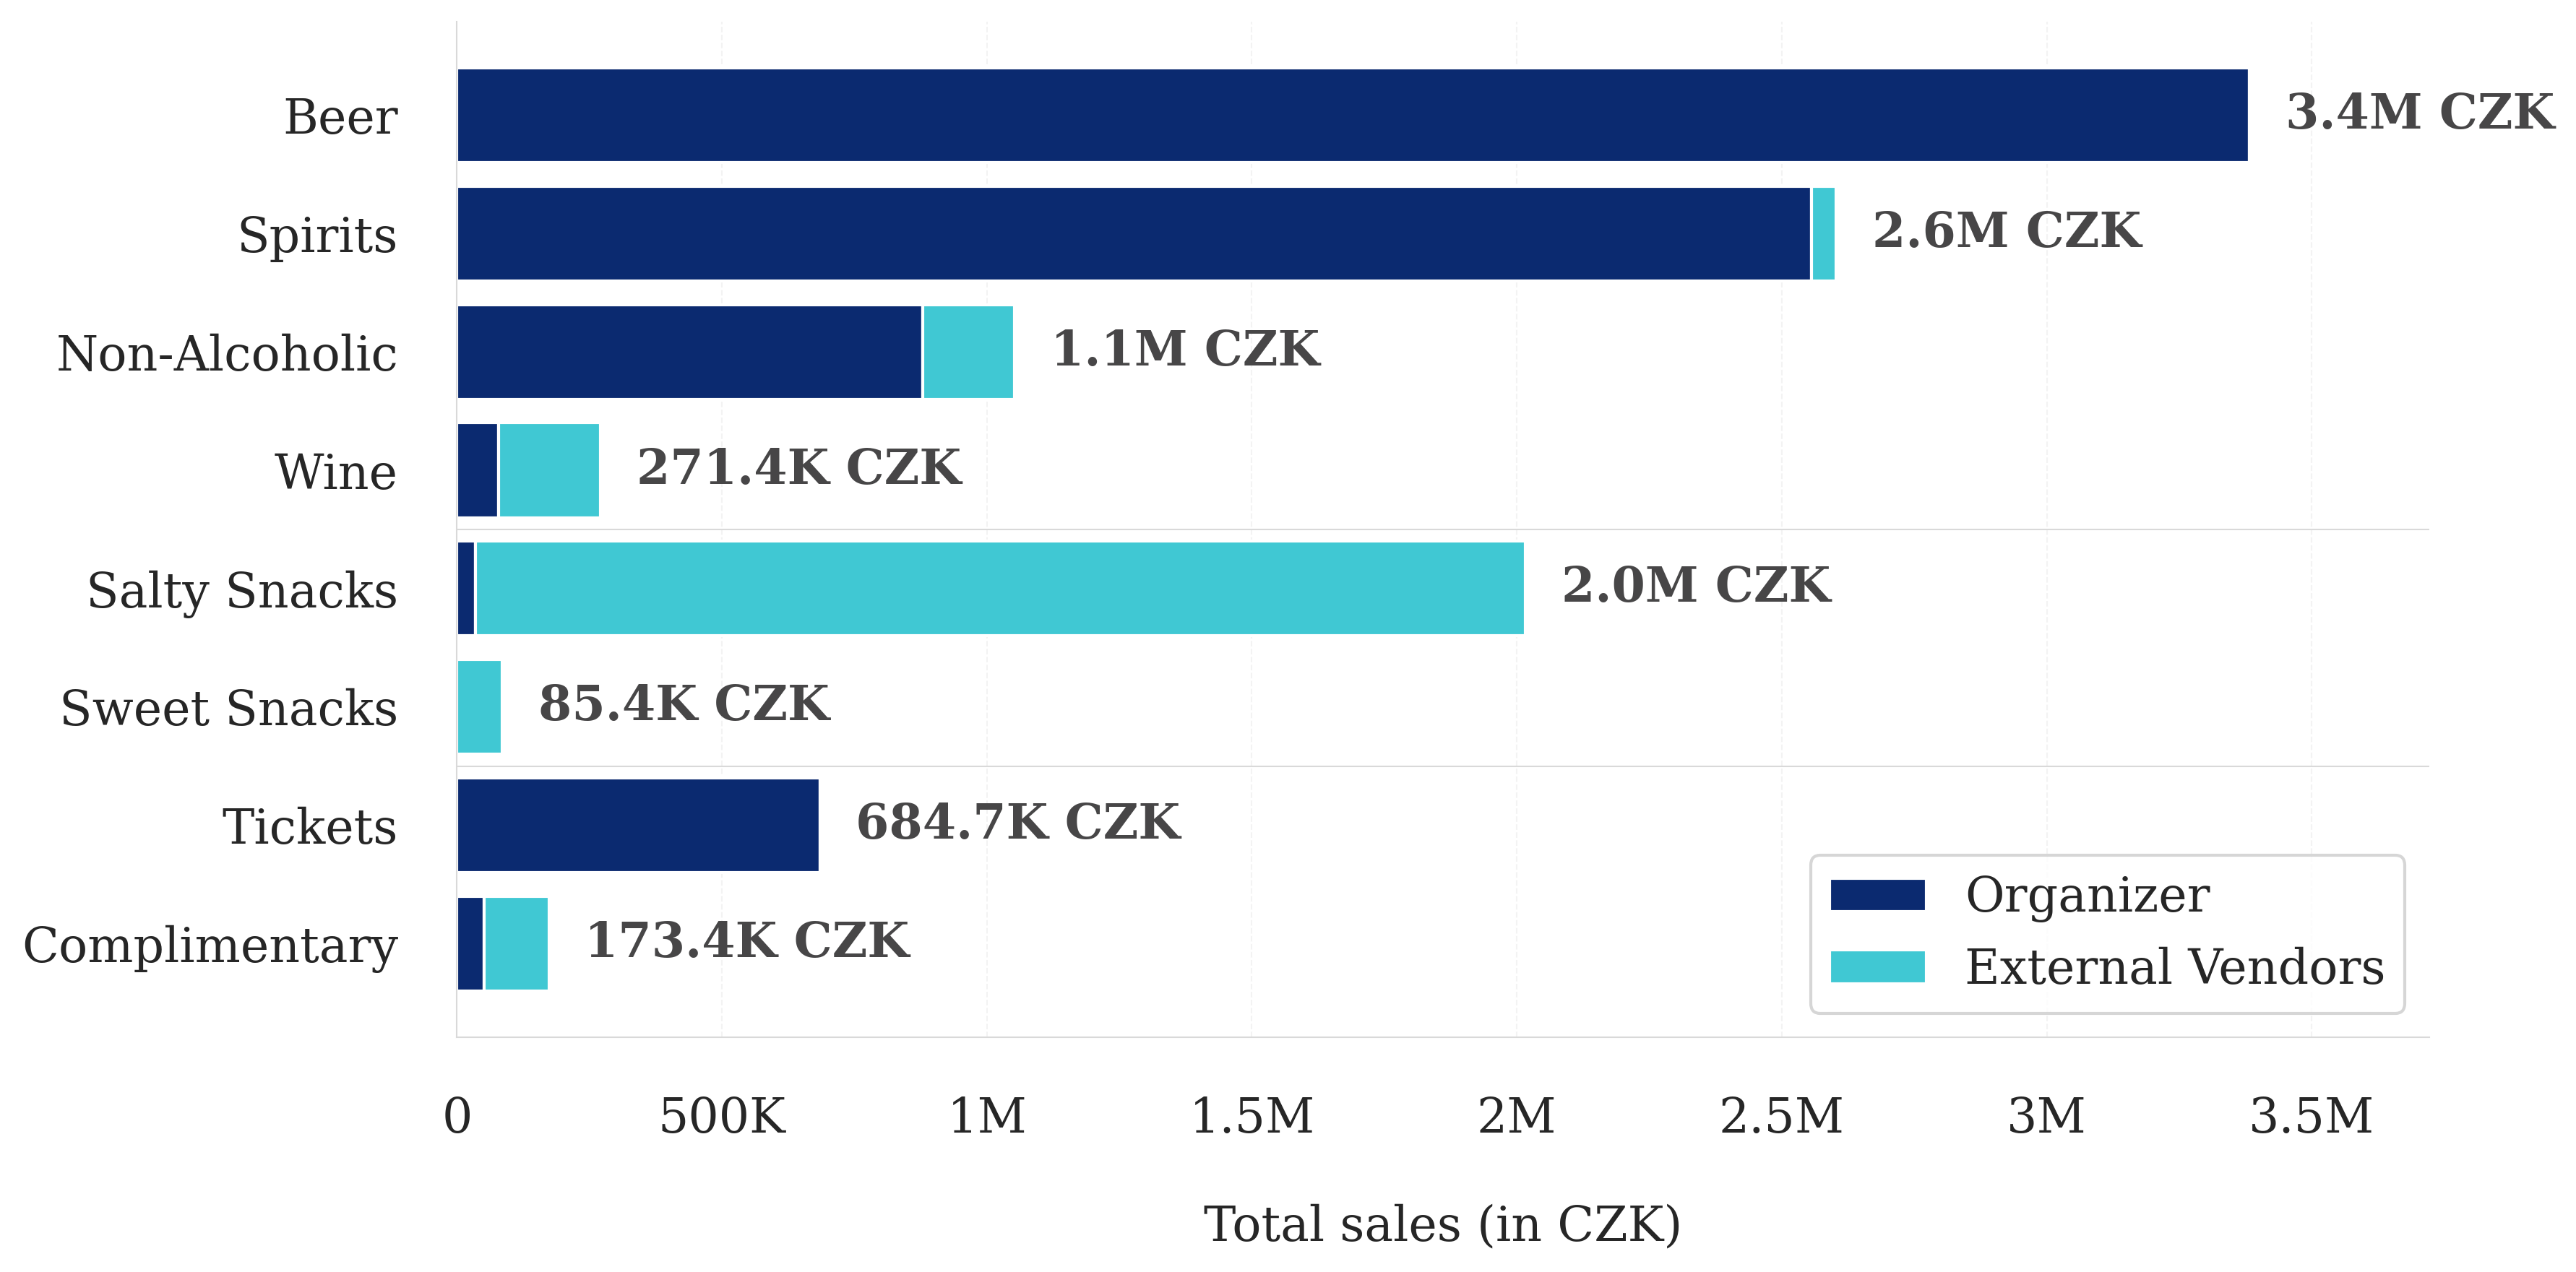

In [52]:
import matplotlib.pyplot as plt

data = load_data("rq4-organizer-vs-vendor-sales.csv")

# Define category order and grouping (reversed for bottom-to-top display)
category_order = [
	'complimentary', 'ticket',  # Other
	'sweet', 'salty',  # Food
	'wine', 'non_alcoholic', 'spirits', 'beer'  # Beverages
]

category_labels = {
	"beer": "Beer",
	"spirits": "Spirits",
	"non_alcoholic": "Non-Alcoholic",
	"wine": "Wine",
	"salty": "Salty Snacks",
	"sweet": "Sweet Snacks",
	"ticket": "Tickets",
	"complimentary": "Complimentary"
}

# Prepare data
organizer_values = data.loc[data['source'] == 'organizer', category_order].iloc[0]
external_values = data.loc[data['source'] == 'external', category_order].iloc[0]
total_values = organizer_values + external_values

# Create figure
fig, ax = plt.subplots(figsize=(12, 6))

# Plot bars
y_positions = range(len(category_order))
bars_organizer = ax.barh(
	y_positions, organizer_values,
	label="Organizer",
	color=get_chart_color(0),
	edgecolor='white'
)
bars_external = ax.barh(
	y_positions, external_values, left=organizer_values,
	label="External Vendors",
	color=get_chart_color(1),
	edgecolor='white'
)

# Add category labels
ax.set_yticks(y_positions)
ax.set_yticklabels([category_labels[cat] for cat in category_order], fontsize=16)
# y-ticks fontsize=16, pad=5
ax.tick_params(axis='y', which='major', labelsize=16, pad=16)

# Add value and percentage labels
for i, (org_val, ext_val) in enumerate(zip(organizer_values, external_values)):
	total = org_val + ext_val

	# Add total value
	ax.text(
		total + (max(total_values) * 0.02), i,
		format_price_short(total),
		va='center', ha='left', fontsize=16, color=get_chart_color('text'), fontweight='bold'
	)

# Add gridlines
ax.grid(axis='x', linestyle='--', alpha=0.3, zorder=-1)

# Add group separators
group_separators = [1.5, 3.5]  # Adjusted positions for reversed order
for sep in group_separators:
	ax.axhline(y=sep, color='#d9d9d9', linestyle='-', linewidth=0.5)

# Customize chart
ax.set_xlabel("Total sales (in CZK)", fontsize=16, labelpad=20)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: format_number_short(x / 100)))
# x-ticks fontsize=16, pad=10
ax.tick_params(axis='x', which='major', labelsize=16, pad=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(fontsize=16, loc="lower right")

ax.grid(axis='y', linestyle='--', alpha=0)

ax.set_xlim(0, max(total_values) * 1.1)

# Add group labels with adjusted positions
# ax.text(
#     -max(total_values) * 0.15, 6.5, "Beverages", rotation=90,
#     va='center', ha='center', fontsize=10, color='#474647'
# )
# ax.text(
#     -max(total_values) * 0.15, 2.5, "Food", rotation=90,
#     va='center', ha='center', fontsize=10, color='#474647'
# )
# ax.text(
#     -max(total_values) * 0.15, 0.5, "Other", rotation=90,
#     va='center', ha='center', fontsize=10, color='#474647'
# )

plt.tight_layout()
plt.savefig(get_charts_dir("rq4-organizer-vs-vendor-sales.png"), dpi=300, bbox_inches='tight', pad_inches=0.1)



In [159]:
import plotly.graph_objects as go
from dashboard_app._chart_utils import SankeyDiagram


def format_value(value, show_percentage=False, total=None, group_total=None):
	"""Format values with simplified formatting to match thesis"""
	val_str = format_price_short(value)

	if show_percentage:
		percentage = value / (total or group_total) * 100
		val_str = f'{val_str} ({format_percent(percentage)})'

	return val_str


# Create Sankey diagram
sankey = SankeyDiagram()

# Data preparation
remaining_amount = 353602800
refunded_amount = 317894600
non_refundable = 2265100
unclaimed = 33443100

# Add nodes (x,y will be overridden later)
sankey.add_node(
	'remaining',
	f'Remaining Credit {format_value(remaining_amount)}',
	0, 0, 'stone'
)

sankey.add_node(
	'refunded',
	f'Refunded {format_value(refunded_amount, False, remaining_amount)}',
	0, 0, 'stone'
)

sankey.add_node(
	'non_refundable',
	f'Non-refundable {format_value(non_refundable, False, remaining_amount)}',
	0, 0, 'crimson'
)

sankey.add_node(
	'unclaimed',
	f'Unclaimed {format_value(unclaimed, False, remaining_amount)}',
	0, 0, 'lime'
)

sankey.add_node(
	'bank',
	f'Bank Refunds {format_value(316356700, False, group_total=refunded_amount)}',
	0, 0, 'stone'
)

sankey.add_node(
	'pos',
	f'On-site Refunds {format_value(1537900, False, group_total=refunded_amount)}',
	0, 0, 'stone'
)

sankey.add_node(
	'vip',
	f'VIP Credit {format_value(1240500, False, group_total=non_refundable)}',
	0, 0, 'crimson'
)

sankey.add_node(
	'integrity',
	f'Integrity Errors {format_value(1024600, False, group_total=non_refundable)}',
	0, 0, 'crimson'
)

# Add invisible target nodes for final layer
sankey.add_node(
	'bank_end',
	'',  # Empty label
	0, 0, 'white'  # White color makes it invisible
)

sankey.add_node(
	'pos_end',
	'',
	0, 0, 'white'
)

sankey.add_node(
	'vip_end',
	'',
	0, 0, 'white'
)

sankey.add_node(
	'integrity_end',
	'',
	0, 0, 'white'
)

# Add flows
sankey.add_flow('remaining', 'refunded', refunded_amount, 'stone')
sankey.add_flow('remaining', 'non_refundable', non_refundable, 'crimson')
sankey.add_flow('remaining', 'unclaimed', unclaimed, 'lime')

sankey.add_flow('refunded', 'bank', 316356700, 'stone')
sankey.add_flow('refunded', 'pos', 1537900, 'stone')
sankey.add_flow('non_refundable', 'vip', 1240500, 'crimson')
sankey.add_flow('non_refundable', 'integrity', 1024600, 'crimson')

# Add tiny flows to invisible nodes
sankey.add_flow('bank', 'bank_end', 1, 'white')
sankey.add_flow('pos', 'pos_end', 1, 'white')
sankey.add_flow('vip', 'vip_end', 1, 'white')
sankey.add_flow('integrity', 'integrity_end', 1, 'white')

# Get the plotly dict and override positioning
plotly_dict = sankey.to_plotly()
node_dict = plotly_dict['node']

# Update node positions to move final stage more to the right
# Update node positions
node_dict.update(
	{
		'x': [
			0.05,  # Remaining Credit (moved left from 0.1)
			0.45,  # Refunded
			0.45,  # Non-refundable
			0.45,  # Unclaimed
			0.85,  # Bank Refunds
			0.85,  # On-site Refunds
			0.85,  # VIP Credit
			0.85,  # Integrity Errors
			1.0,  # Bank end (invisible)
			1.0,  # POS end (invisible)
			1.0,  # VIP end (invisible)
			1.0  # Integrity end (invisible)
		],
		'y': [
			0.44,  # Remaining Credit
			0.4,  # Refunded
			0.6,  # Non-refundable
			0.7,  # Unclaimed
			0.4,  # Bank Refunds
			0.5,  # On-site Refunds
			0.7,  # VIP Credit
			0.7,  # Integrity Errors
			0.75,  # Bank end
			0.75,  # POS end
			0.75,  # VIP end
			0.75  # Integrity end
		],
		'pad': 25,
		'thickness': 15,
		'line': { 'color': "black", 'width': 0 }
	}
)

# Create figure with updated font and positioning
fig = go.Figure(
	data=[go.Sankey(
		arrangement="snap",
		node=node_dict,
		link={
			**plotly_dict['link'],
			'color': [*[c for c in plotly_dict['link']['color'][:-4]],
			          *['rgba(255,255,255,0)'] * 4]  # Make last 4 flows invisible
		},
		textfont={
			"size": 18,
			"family": "serif"
		}
	)]
)

scale = 1
# Update layout with consistent font
fig.update_layout(
	font=dict(
		size=24 * scale,
		family="serif",
		weight="bold",
		color=get_chart_color('text'),
	),
	paper_bgcolor='white',
	plot_bgcolor='white',
	width=900,
	height=400,
	# Increase right margin to accommodate labels
	margin=dict(t=25, l=0, r=200, b=25),
	annotations=[
		# dict(
		# 	x=0.5,
		# 	y=-0.3,
		# 	xref='paper',
		# 	yref='paper',
		# 	text='Note: Percentages in groups are relative to Remaining Credit,<br>while percentages in detail nodes are relative to their respective group totals',
		# 	showarrow=False,
		# 	font=dict(size=18, family="\"Computer Modern Sans\", serif"),
		# 	align='center'
		# )
	]
)

# Save with high quality
# fig.write_image("credit_flow_thesis.pdf", scale=4)
# fig.write_image("credit_flow_thesis.png", scale=4, width=2400, height=1400)
# fig.write_html("credit_flow_thesis.html")
fig.write_image(get_charts_dir("rq3-remaining-balances.png"), scale=4, width=900, height=400)
fig.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import squarify  # For treemap visualization

# Load data using your function
data_non = load_data("rq29-product-combos-nonreturnable.csv")
data_with = load_data("rq29-product-combos-with-returnable.csv")


def treemap_combos(data):
	# Select top 10 product combinations
	top_combinations = data.nlargest(7, 'combination_count')

	# Prepare the data for the treemap
	sizes = top_combinations['combination_count']

	# Use custom colors for the treemap
	colors = [
		get_chart_color(i) for i in range(len(sizes))
	]

	# Create the treemap
	plt.figure(figsize=(10, 2))
	squarify.plot(sizes=sizes, color=colors, bar_kwargs=dict(linewidth=0))

	# Remove labels
	plt.axis('off')
	plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
	return plt


# Show the treemap
plt1 = treemap_combos(data_non)
plt1.savefig(get_charts_dir("rq29-product-combos-nonreturnable.png"), dpi=300, bbox_inches='tight', pad_inches=0)
plt2 = treemap_combos(data_with)
plt2.savefig(get_charts_dir("rq29-product-combos-with-returnable.png"), dpi=300, bbox_inches='tight', pad_inches=0)

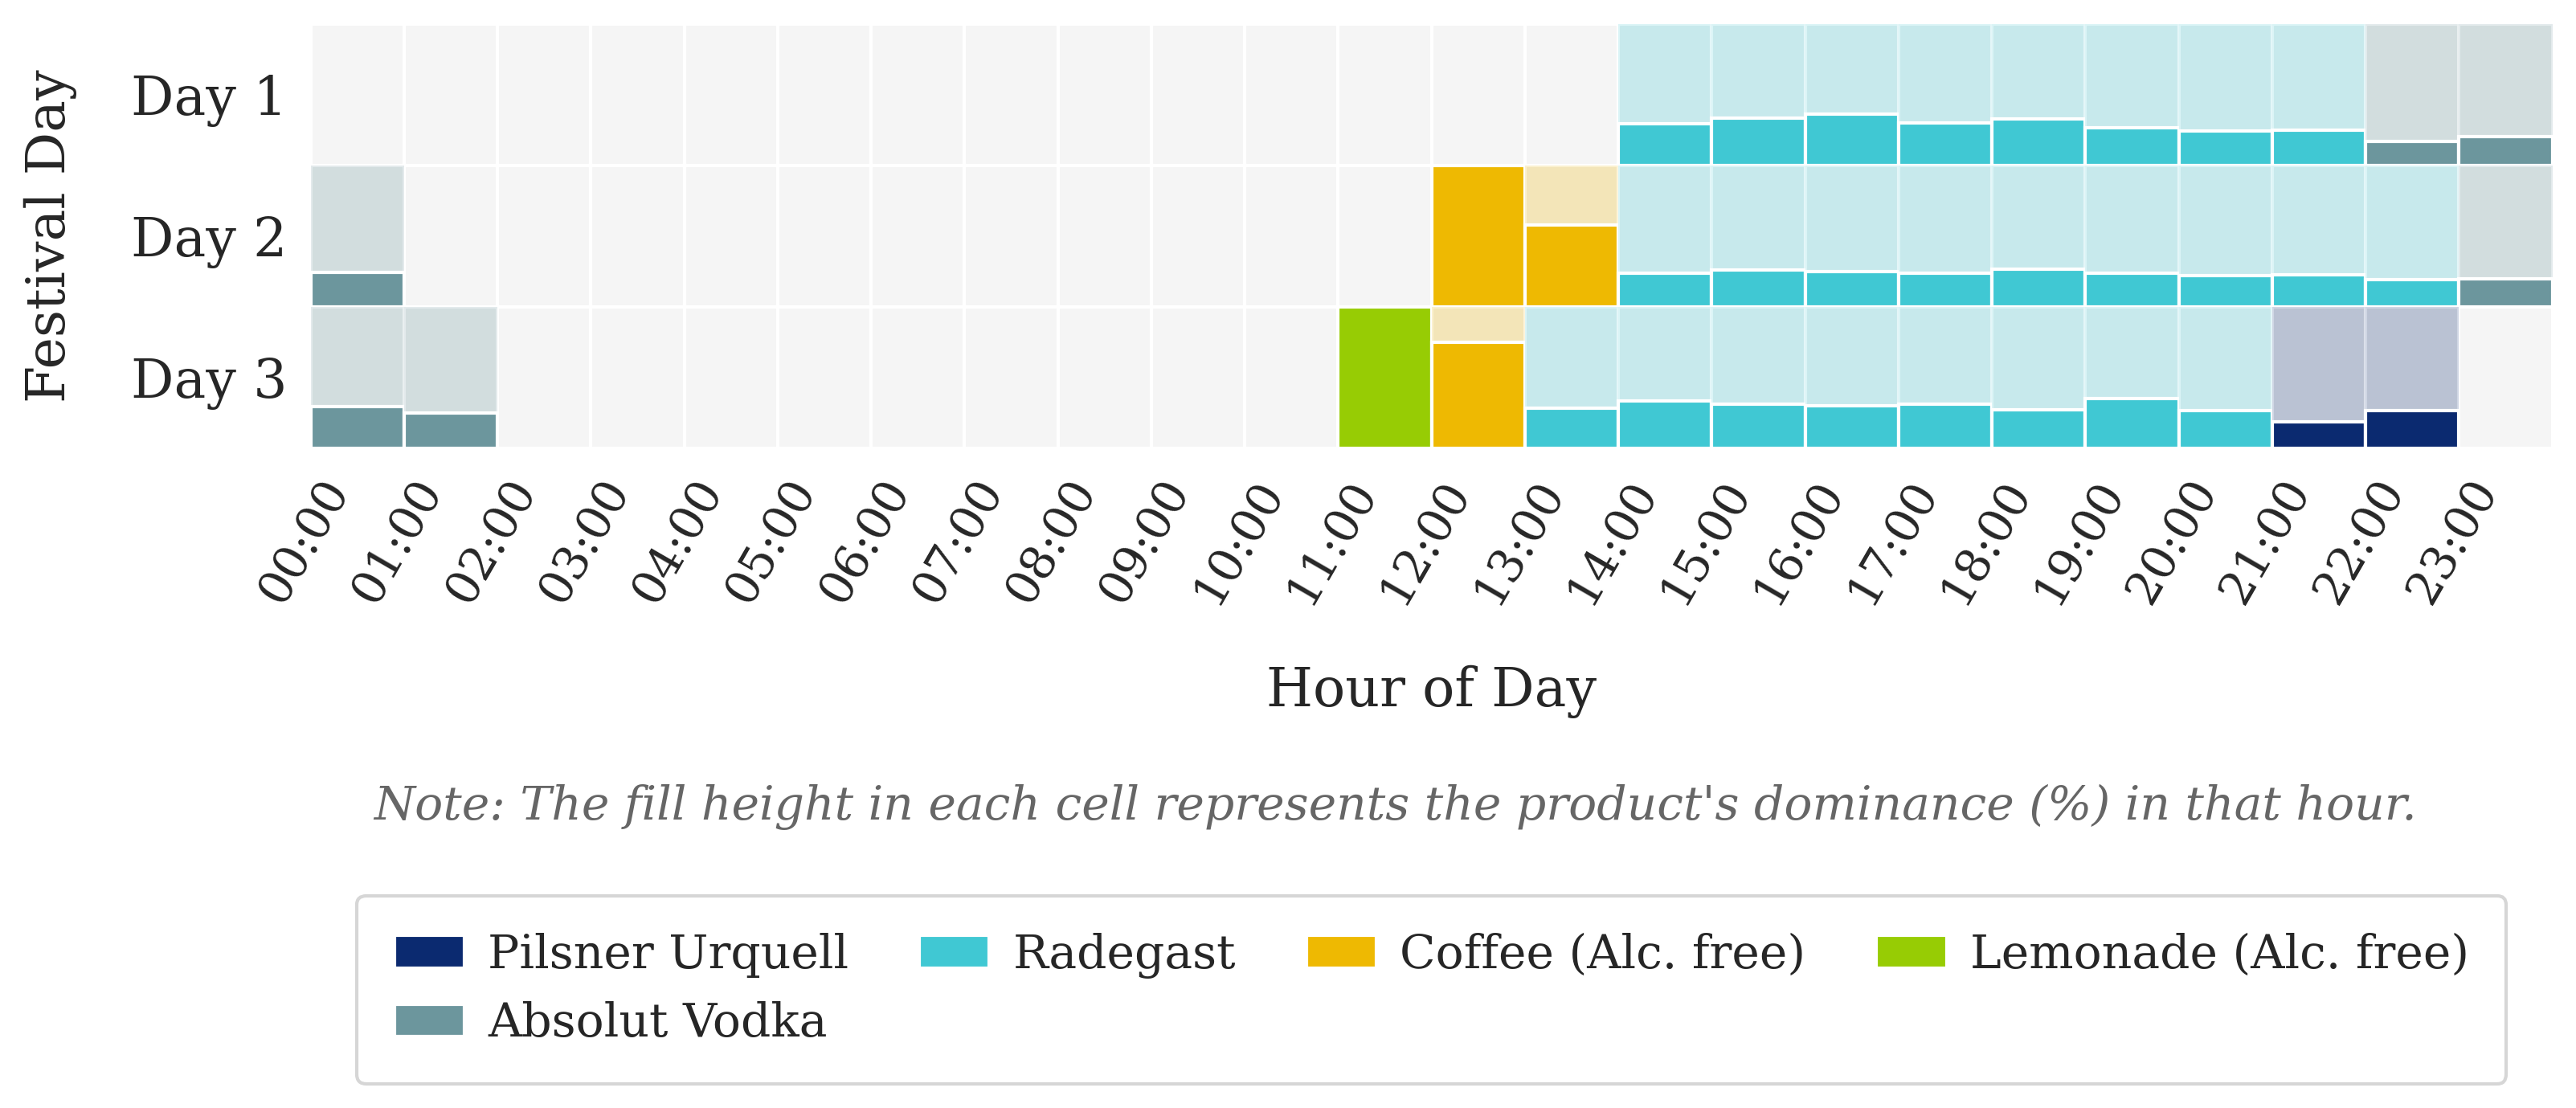

In [68]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.gridspec import GridSpec

# Load and prepare data
df = load_data("rq28-beverage-prefs.csv")
df['datetime'] = pd.to_datetime(df['hour'])
df['day'] = df['datetime'].apply(lambda x: format_event_datetime(x, include_time=False))
df['hour_num'] = df['datetime'].dt.hour

# Color scheme
colors = {
	# 'Radegast': '#97AA84',
	# 'Pilsner Urquell': '#355935',
	# 'Absolut Vodka': '#78C6F5',
	# 'Lemonade': '#E3E3AA',
	# 'Coffee': '#474647',
	'Pilsner Urquell': get_chart_color(0),
	'Radegast': get_chart_color(1),
	'Absolut Vodka': get_chart_color(2),
	'Lemonade': get_chart_color(3),
	'Coffee': get_chart_color(4),
}

# Create figure with specific layout
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 16

# Create figure and gridspec
fig = plt.figure(figsize=(12, 6), facecolor='white')
gs = GridSpec(2, 1, height_ratios=[3, 1], figure=fig)

# Create main plot
ax = fig.add_subplot(gs[0])
ax.set_facecolor('#f5f5f5')

# Create heatmap
days = ['Day 1', 'Day 2', 'Day 3']
hours = range(24)

# First add background for all cells
for i in range(3):
	for j in range(24):
		ax.add_patch(plt.Rectangle((j, 2 - i), 1, 1, facecolor='#f5f5f5', edgecolor='white', linewidth=1))

# Then add colored patches for data with two-layer approach
for i, day in enumerate(days):
	for j, hour in enumerate(hours):
		mask = (df['day'] == day) & (df['hour_num'] == hour)
		if mask.any():
			data = df[mask].iloc[0]
			base_color = colors[data['category']]

			# Convert color to RGB for opacity control
			rgb = plt.cm.colors.to_rgb(base_color)

			# First layer: Full box with low opacity
			ax.add_patch(
				plt.Rectangle(
					(j, 2 - i), 1, 1,
					facecolor=base_color,
					edgecolor='white',
					linewidth=1,
					alpha=0.25  # Low opacity for background
				)
			)

			# Second layer: Partial box showing dominance
			height = data['hour_percentage'] / 100  # Convert percentage to decimal
			ax.add_patch(
				plt.Rectangle(
					(j, 2 - i),  # Same x, starting from bottom
					1,  # Full width
					height,  # Height based on percentage
					facecolor=base_color,
					edgecolor=None,  # No edge to blend better
					alpha=1.0  # Full opacity for dominance indicator
				)
			)

# Customize the plot
ax.set_xlim(0, 24)
ax.set_ylim(0, 3)

# Set ticks and labels
ax.set_xticks(np.arange(24) + 0.5)
ax.set_xticklabels(
	[f'{h:02d}:00' for h in hours],
	rotation=60,
	ha='right',
	fontsize=14
)
ax.set_yticks(np.arange(3) + 0.5)
ax.set_yticklabels(days[::-1], fontsize=16)

# Remove spines
for spine in ax.spines.values():
	spine.set_visible(False)

# Set labels
ax.set_xlabel('Hour of Day', labelpad=16, fontsize=16)
ax.set_ylabel('Festival Day', labelpad=16, fontsize=16)

# Create legend elements
alcoholic_products = [p for p in df[df['is_alcoholic']]['category'].unique()]
non_alcoholic_products = [p for p in df[~df['is_alcoholic']]['category'].unique()]

# Create simple legend elements
legend_elements = [
	plt.Rectangle((0, 0), 1, 1, facecolor=colors[product])
	for product in ['Pilsner Urquell', 'Absolut Vodka', 'Radegast', 'Coffee', 'Lemonade']
]

legend_labels = ['Pilsner Urquell', 'Absolut Vodka', 'Radegast', 'Coffee (Alc. free)', 'Lemonade (Alc. free)']

# Create legend with wide span
legend = ax.legend(
	legend_elements,
	legend_labels,
	bbox_to_anchor=(0.5, -1),  # Centered, closer to plot
	loc='upper center',
	ncol=4,  # All items in one row
	fontsize=14,
	frameon=True,
	edgecolor='#cccccc',
	borderpad=0.8,
	columnspacing=1.5,  # Space between columns
	handletextpad=0.5,  # Space between square and text
	handlelength=1.5,  # Square size
)

# After the legend creation, add an annotation
fig.text(
	0.5, 0.33,
	'Note: The fill height in each cell represents the product\'s dominance (%) in that hour.',
	ha='center',
	fontsize=14,
	color='#666666',
	style='italic'
)

# Adjust layout
plt.subplots_adjust(bottom=0.45)

plt.savefig(get_charts_dir("rq28-beverage-preferences.png"), dpi=300, bbox_inches='tight', pad_inches=0.1)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
from matplotlib.ticker import AutoMinorLocator

# Set up the figure with specific size
df = load_data("rq26-topup-patterns.csv")
df['hour'] = pd.to_datetime(df['hour'])

plt.figure(figsize=(12, 6))
ax1 = plt.gca()
ax2 = ax1.twinx()

# Set y-axis limits with padding to prevent overflow
max_topups = df['topup_count'].max()
y_max = max_topups * 1.15  # Add 15% padding
ax1.set_ylim(0, y_max)
ax2.set_ylim(0, df['total_topup_count'].max() * 1.05)  # 5% padding for cumulative

# Create bar chart for hourly top-ups
x = mdates.date2num(df['hour'])
width = (x[1] - x[0]) * 0.8

bars = ax1.bar(
	x,
	df['topup_count'],
	width=width,
	color=get_chart_color(2),
)

# Plot cumulative line
line = ax2.plot(
	x,
	df['total_topup_count'],
	color=get_chart_color(3),
	linewidth=2,
	label='Cumulative Total'
)

# Improve grid styling
ax1.set_axisbelow(True)
ax2.set_axisbelow(True)
ax1.grid(axis='y', linestyle='--', alpha=0.5)
ax2.grid(axis='y', linestyle='--', alpha=0)

peak_positions = []
peak_times = []

# Find daily peaks and highlight them
for day in pd.date_range('2024-07-04', '2024-07-06'):
	day_data = df[df['hour'].dt.strftime('%Y-%m-%d') == day.strftime('%Y-%m-%d')]
	if len(day_data) > 0:
		peak_hour = day_data.nlargest(1, 'topup_count').iloc[0]
		idx = df.index[df['hour'] == peak_hour['hour']][0]
		bars[idx].set_color(get_chart_color(0))
		bars[idx].set_alpha(1.0)

		peak_positions.append(x[idx])
		peak_times.append(peak_hour['hour'])

		# Improve peak annotations
		ax1.annotate(
			f'{int(peak_hour["topup_count"]):,}',
			xy=(x[idx], peak_hour['topup_count']),
			xytext=(0, 15),  # Increased vertical offset
			textcoords='offset points',
			ha='center',
			va='bottom',
			fontweight='bold',
			fontsize=16,
			bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=1)
		)

# Format axes with improved spacing
ax1.set_ylabel('New Top-ups per Hour', fontsize=16, labelpad=24, color=get_chart_color('text'))
ax2.set_ylabel('Cumulative Total', fontsize=16, labelpad=24, color=get_chart_color('text'))
ax1.tick_params(axis='both', labelsize=16)
ax2.tick_params(axis='y', labelsize=16)

# Format x-axis
ax1.set_xticks(peak_positions)
ax1.xaxis.set_major_formatter(
	plt.FuncFormatter(
		lambda x, p: format_event_datetime(mdates.num2date(x))
	)
)
plt.xticks(rotation=45, ha='right')

# Format y-axis numbers
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format_number_short(x)))
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format_number_short(x)))

# Improved legend - moved below the chart
legend_elements = [
	plt.Rectangle((0, 0), 1, 1, color=get_chart_color(2), alpha=0.8, label='Hourly Top-ups'),
	plt.Rectangle((0, 0), 1, 1, color=get_chart_color(0), label='Peak Hours'),
	plt.Line2D([0], [0], color=get_chart_color(3), label='Cumulative Total')
]
ax1.legend(
	handles=legend_elements,
	loc='upper center',
	fontsize=16,
	bbox_to_anchor=(0.5, -0.15),  # Moved below by adjusting y coordinate
	ncol=3
)

# Adjust layout with more bottom padding to accommodate legend
plt.tight_layout(rect=[0, 0.1, 1, 1])  # Added padding at bottom [left, bottom, right, top]

plt.savefig(get_charts_dir("rq26-topup-patterns.png"), dpi=300, bbox_inches='tight', pad_inches=0.1)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
from matplotlib.ticker import AutoMinorLocator

# Set up the figure with specific size
df = load_data("rq24-arrival-patterns.csv")
df['hour'] = pd.to_datetime(df['hour'])

plt.figure(figsize=(12, 6))
ax1 = plt.gca()
ax2 = ax1.twinx()

# Set y-axis limits with padding to prevent overflow
max_registrations = df['register_count'].max()
y_max = max_registrations * 1.15  # Add 15% padding
ax1.set_ylim(0, y_max)
ax2.set_ylim(0, df['total_register_count'].max() * 1.05)  # 5% padding for cumulative

# Create bar chart for hourly top-ups
x = mdates.date2num(df['hour'])
width = (x[1] - x[0]) * 0.8

bars = ax1.bar(
	x,
	df['register_count'],
	width=width,
	color=get_chart_color(2),
)

# Plot cumulative line
line = ax2.plot(
	x,
	df['total_register_count'],
	color=get_chart_color(3),
	linewidth=2,
	label='Cumulative Total'
)

# Improve grid styling
ax1.set_axisbelow(True)
ax2.set_axisbelow(True)
ax1.grid(axis='y', linestyle='--', alpha=0.5)
ax2.grid(axis='y', linestyle='--', alpha=0)

peak_positions = []
peak_times = []

# Find daily peaks and highlight them
for day in pd.date_range('2024-07-04', '2024-07-06'):
	day_data = df[df['hour'].dt.strftime('%Y-%m-%d') == day.strftime('%Y-%m-%d')]
	if len(day_data) > 0:
		peak_hour = day_data.nlargest(1, 'register_count').iloc[0]
		idx = df.index[df['hour'] == peak_hour['hour']][0]
		bars[idx].set_color(get_chart_color(0))
		bars[idx].set_alpha(1.0)

		peak_positions.append(x[idx])
		peak_times.append(peak_hour['hour'])

		# Improve peak annotations
		ax1.annotate(
			f'{int(peak_hour["register_count"]):,}',
			xy=(x[idx], peak_hour['register_count']),
			xytext=(0, 15),  # Increased vertical offset
			textcoords='offset points',
			ha='center',
			va='bottom',
			fontweight='bold',
			fontsize=16,
			bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=1)
		)

# Format axes with improved spacing
ax1.set_ylabel('New Arrivals per Hour', fontsize=16, labelpad=24, color=get_chart_color('text'))
ax2.set_ylabel('Cumulative Total', fontsize=16, labelpad=24, color=get_chart_color('text'))
ax1.tick_params(axis='both', labelsize=16)
ax2.tick_params(axis='y', labelsize=16)

# Format x-axis
ax1.set_xticks(peak_positions)
ax1.xaxis.set_major_formatter(
	plt.FuncFormatter(
		lambda x, p: format_event_datetime(mdates.num2date(x))
	)
)
plt.xticks(rotation=45, ha='right')

# Format y-axis numbers
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format_number_short(x)))
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format_number_short(x)))

# Improved legend - moved below the chart
legend_elements = [
	plt.Rectangle((0, 0), 1, 1, color=get_chart_color(2), alpha=0.8, label='Hourly Arrivals'),
	plt.Rectangle((0, 0), 1, 1, color=get_chart_color(0), label='Peak Hours'),
	plt.Line2D([0], [0], color=get_chart_color(3), label='Cumulative Total')
]
ax1.legend(
	handles=legend_elements,
	loc='upper center',
	fontsize=16,
	bbox_to_anchor=(0.5, -0.15),  # Moved below by adjusting y coordinate
	ncol=3
)

# Adjust layout with more bottom padding to accommodate legend
plt.tight_layout(rect=[0, 0.1, 1, 1])  # Added padding at bottom [left, bottom, right, top]

plt.savefig(get_charts_dir("rq24-arrival-patterns.png"), dpi=300, bbox_inches='tight', pad_inches=0.1)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read and prepare data
df = load_data("rq27-topup-frequency.csv")

# Create categories for number of topups
categories = ['0 top-ups', '1 top-up', '2 top-ups', '3 top-ups', '4+ top-ups']
chip_types = ['Pass', 'POS', 'Guest', 'Staff', 'POS VIP']

# Process data
data_matrix = np.zeros((len(categories), len(chip_types)))

for i, cat_idx in enumerate(range(5)):  # 0 through 4+
	for j, chip in enumerate(chip_types):
		chip_data = df[df['chip_type'] == chip]
		if cat_idx == 4:  # 4+ category
			count = chip_data[chip_data['onsite_topup_count'] >= 4]['count'].sum()
		else:
			count = chip_data[chip_data['onsite_topup_count'] == cat_idx]['count'].sum()
		data_matrix[i, j] = count

# Create horizontal stacked bar chart
fig, ax = plt.subplots(figsize=(12, 6))

left = np.zeros(len(categories))
bars = []
colors = [get_chart_color(i) for i in range(len(chip_types))]

# Calculate row sums for totals
row_sums = data_matrix.sum(axis=1)

for i, chip in enumerate(chip_types):
	labels = {
		'Pass': 'Online',
		'POS': 'Regular',
		'Guest': 'Guest',
		'Staff': 'Staff',
		'POS VIP': 'VIP',
	}
	bar = ax.barh(
		categories, data_matrix[:, i], left=left,
		color=colors[i],
		label=labels[chip],
		edgecolor='white',
	)
	left += data_matrix[:, i]
	bars.append(bar)

# Add total values to the left of bars
for idx, total in enumerate(row_sums):
	ax.text(
		total + 42,
		idx,
		f"{format_number(total, 0)} ({format_percent(total / row_sums.sum() * 100)})",
		ha='left',
		va='center',
		color=get_chart_color('text'),
		fontsize=16,
		fontweight='bold'
	)

ax.set_xlabel('Number of Customers', fontsize=16, labelpad=24, color=get_chart_color('text'))
ax.tick_params(axis='both', labelsize=16)

# Add legend below the chart
ax.legend(
	loc='upper center',
	bbox_to_anchor=(0.5, -0.25),
	ncol=len(chip_types),
	fontsize=16
)

# Format axis
ax.grid(False)
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

x_max = data_matrix.sum(axis=1).max() * 1.3
ax.set_xlim(0, x_max)

# Adjust layout and margins to accommodate the totals
plt.tight_layout(rect=[0.1, 0, 1, 1])  # Increased left margin

plt.savefig(get_charts_dir("rq27-topup-frequency.png"), dpi=300, bbox_inches='tight', pad_inches=0.1)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Data preparation
data = {
	'count': [2537, 1505, 5340, 3247],
	'payment_type': ['online', 'online', 'onsite', 'onsite'],
	'card': ['VISA', 'MC', 'VISA', 'MC']
}
df = pd.DataFrame(data)

# Group data by payment type and card
grouped = df.groupby(['payment_type', 'card'])['count'].sum().unstack()

# Extract data for each payment type
onsite = grouped.loc['onsite'][::-1]
online = grouped.loc['online'][::-1]

# Shared settings
colors = ['#1A1F71', '#F79E1B']  # VISA blue, MC orange
labels = ['VISA', 'Mastercard']


def plot_donut(ax, values, title, cls, labels):
	# Calculate total and percentages
	total = sum(values)
	percentages = [v / total * 100 for v in values]

	# Create donut chart
	wedges, texts = ax.pie(
		values,
		colors=cls,
		labels=None,
		autopct=None,
		wedgeprops={
			'width': 0.5,
			'edgecolor': 'white',
			'linewidth': 2
		}
	)

	# Add percentages to the wedges
	for i, p in enumerate(percentages):
		angle = (wedges[i].theta2 + wedges[i].theta1) / 2
		x = 0.85 * wedges[i].r * np.cos(np.radians(angle))
		y = 0.7 * wedges[i].r * np.sin(np.radians(angle))
		ax.text(
			x, y, f'{p:.1f}%', ha='center', va='center',
			fontsize=16, color='white', fontweight='bold'
		)

	# Add white circle in center
	centre_circle = plt.Circle((0, 0), 0.5, color='white', linewidth=0)
	ax.add_artist(centre_circle)

	# Add center text
	ax.text(0, 0.18, 'Total', ha='center', va='center', fontsize=14, fontweight='normal', color='black')
	ax.text(0, -0.02, f'{format_number(total, 0)}', ha='center', va='center', fontsize=28, fontweight='bold', color='black')
	ax.text(0, -0.18, 'transactions', ha='center', va='center', fontsize=14, fontweight='normal', color='black')
	ax.set_title(title, fontsize=20, pad=24, fontweight="bold")


# Create figure and axes
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot donuts
plot_donut(axs[0], onsite.values, 'Onsite Transactions', colors, labels)
plot_donut(axs[1], online.values, 'Online Transactions', colors, labels)

# Add legend
fig.legend(
	labels=[
		f"VISA: {format_number(onsite['VISA'] + online['VISA'], 0)} ({format_percent((onsite['VISA'] + online['VISA']) / df['count'].sum() * 100)})",
		f"Mastercard: {format_number(onsite['MC'] + online['MC'], 0)} ({format_percent((onsite['MC'] + online['MC']) / df['count'].sum() * 100)})"
	],
	loc='lower center',
	bbox_to_anchor=(0.5, -0.05),
	ncol=2,
	fontsize=16,  # Increased font size for legend,
	frameon=True,
	edgecolor='#cccccc',
	borderpad=0.8,
)

# add text above the legend stating the colors represent brand colors of the card schemes
fig.text(
	0.5, 0.1,
	# FIXME
	'Note: Colors used are based on each card scheme\'s brand guidelines.',
	ha='center',
	fontsize=14,
	color='#666666',
	style='italic'
)

# Set aspect ratio and layout
plt.tight_layout(rect=[0, 0.1, 1, 1])

plt.savefig(get_charts_dir("rq23-card-schemes.png"), dpi=300, bbox_inches='tight', pad_inches=0.1)


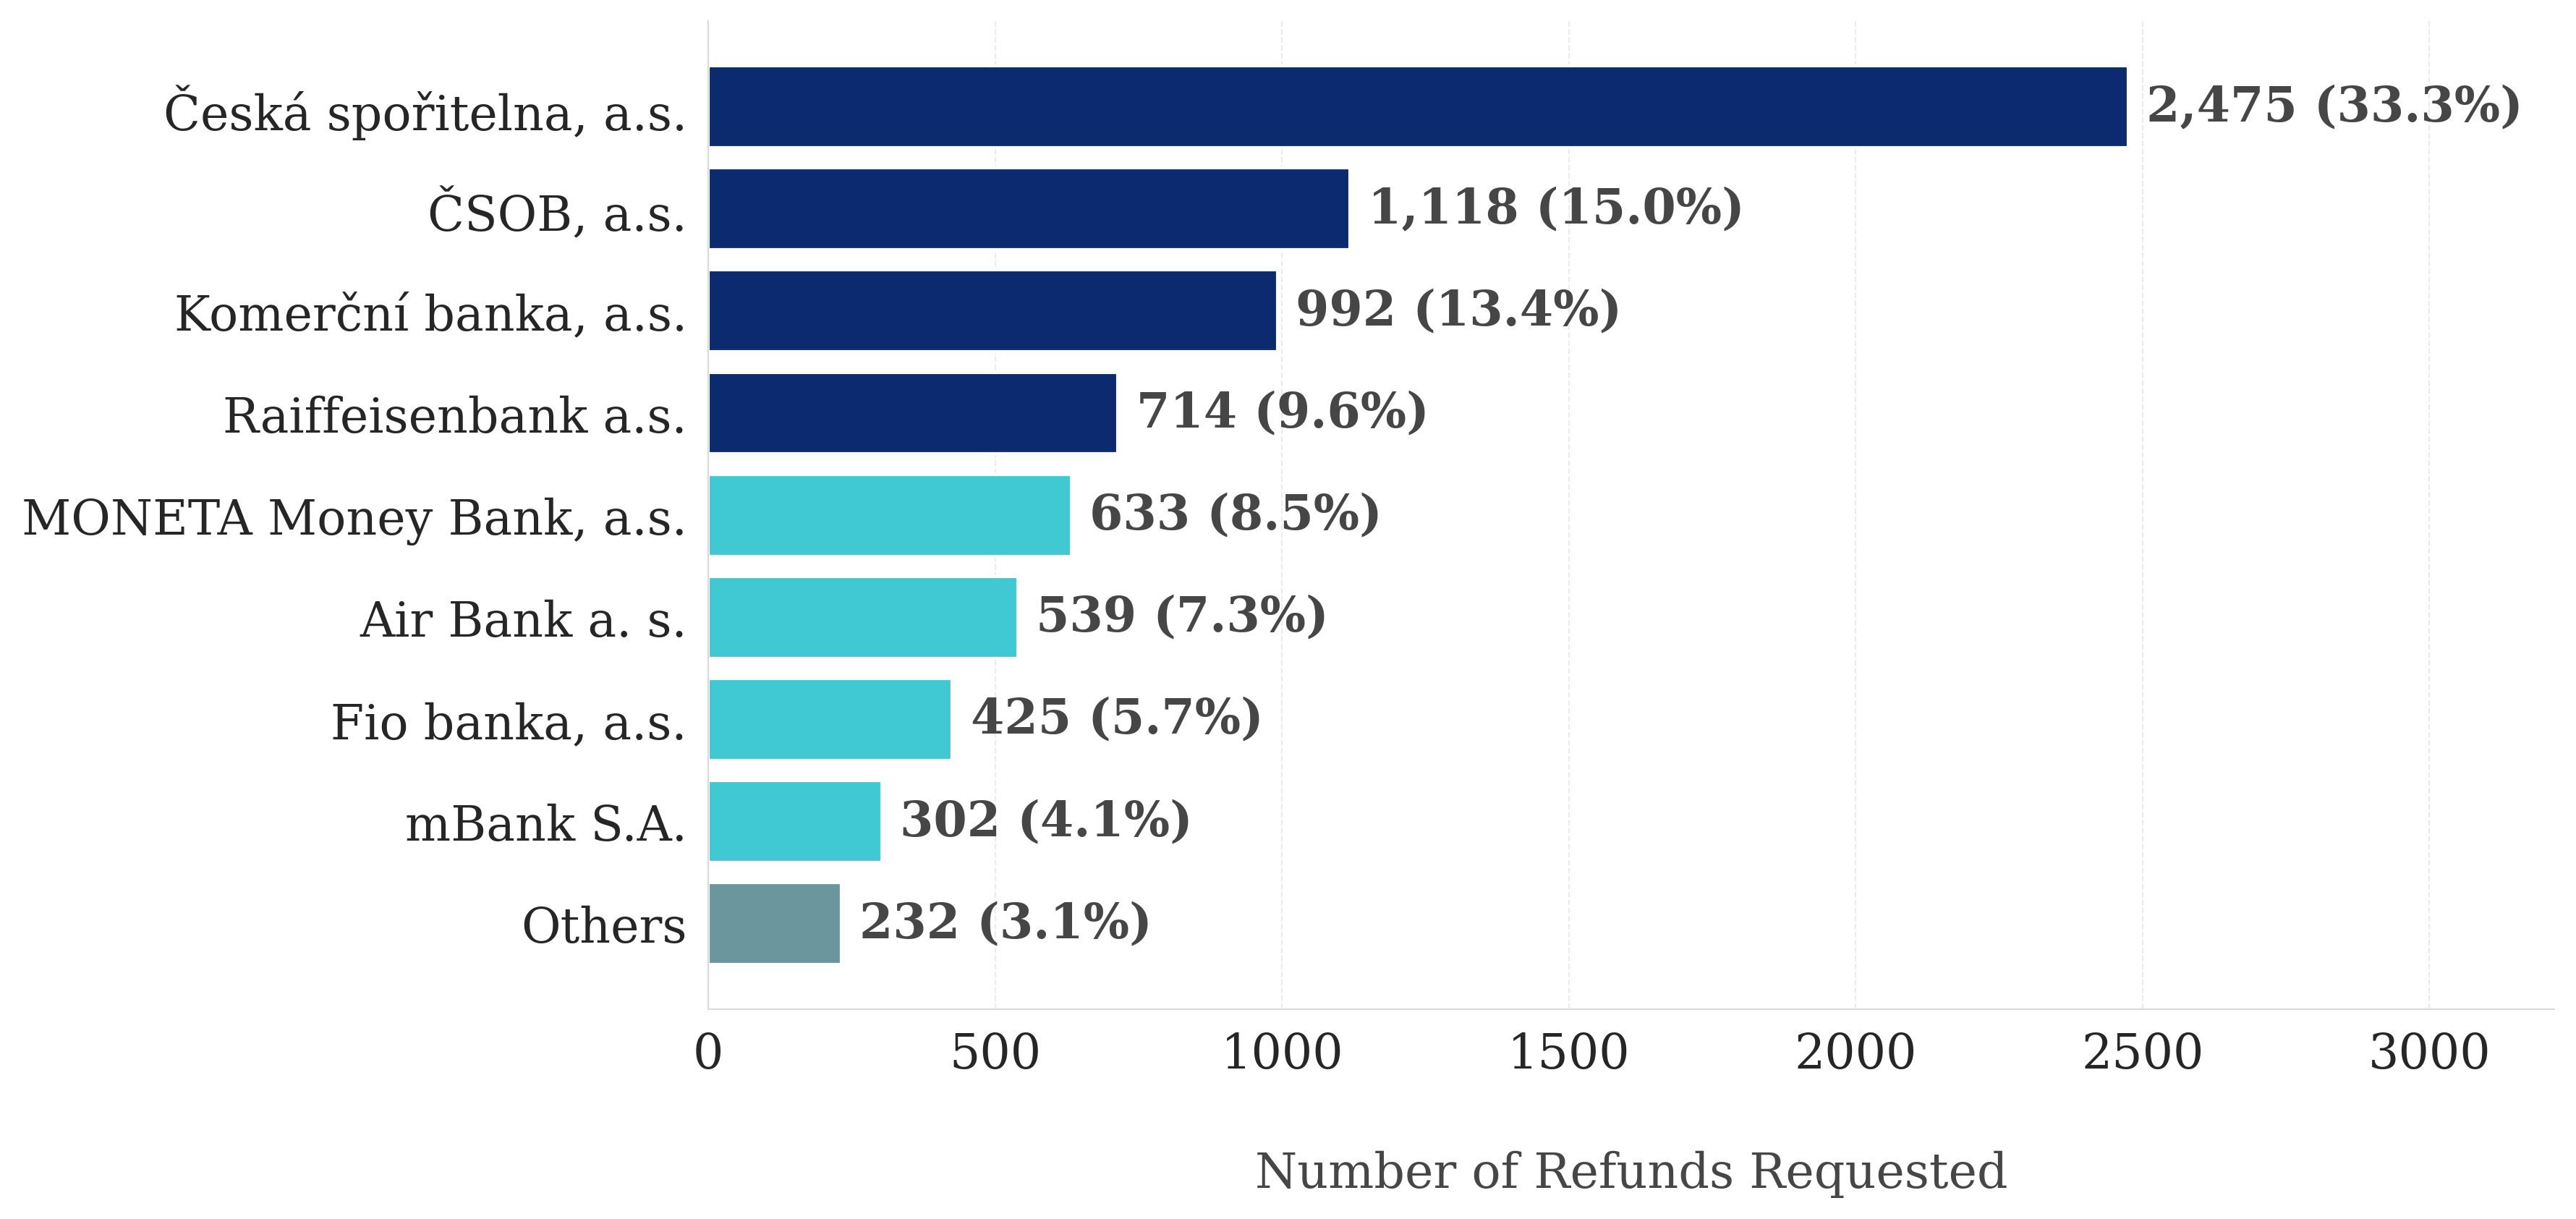

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read and prepare data
df = load_data("rq22-bank-refunds.csv")
# Omit null values
df = df.dropna(subset=['bank_name'])
df = df.sort_values('count', ascending=True)  # Sort for better visualization

# Group smaller banks together
threshold = 300
main_banks = df[df['count'] >= threshold].copy()
others = df[df['count'] < threshold]
others_sum = pd.DataFrame(
	{
		'bank_name': ['Others'],
		'count': [others['count'].sum()]
	}
)

# Combine main banks and others
df_plot = pd.concat([main_banks, others_sum])
df_plot = df_plot.sort_values('count', ascending=True)

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 5.75))

# Create horizontal bars
bars = []
for i, bank in enumerate(df_plot['bank_name']):
	reversed_i = len(df_plot) - i - 1  # Reverse order for better visualization
	bar = ax.barh(
		bank,
		df_plot['count'].iloc[i],
		color=get_chart_color(0 if reversed_i <= 3 else 2 if bank == 'Others' else 1),
	)
	bars.append(bar[0])

# Add value labels on the bars
for bar in bars:
	width = bar.get_width()
	percentage = (width / df['count'].sum()) * 100

	label = f'{int(width):,} ({percentage:.1f}%)'

	ax.text(
		width + 32,  # Slight padding
		bar.get_y() + bar.get_height() / 2,
		label,
		va='center',
		fontsize=16,
		color=get_chart_color('text'),
		fontweight='bold'
	)

# Customize chart
ax.set_xlabel('Number of Refunds Requested', fontsize=16, labelpad=24, color=get_chart_color('text'))
ax.tick_params(axis='both', labelsize=16)

# Format axis
ax.grid(True, axis='x', alpha=0.2)
ax.set_axisbelow(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add padding to x-axis for labels
x_max = df_plot['count'].max()
ax.set_xlim(0, x_max * 1.3)  # Add 25% padding for labels

# hide grid y-axis
ax.grid(axis='y', linestyle='--', alpha=0)
ax.grid(axis='x', linestyle='--', alpha=0.5)

# Adjust layout
plt.tight_layout()

plt.savefig(get_charts_dir("rq22-bank-refunds.png"), dpi=300, bbox_inches='tight', pad_inches=0.1)

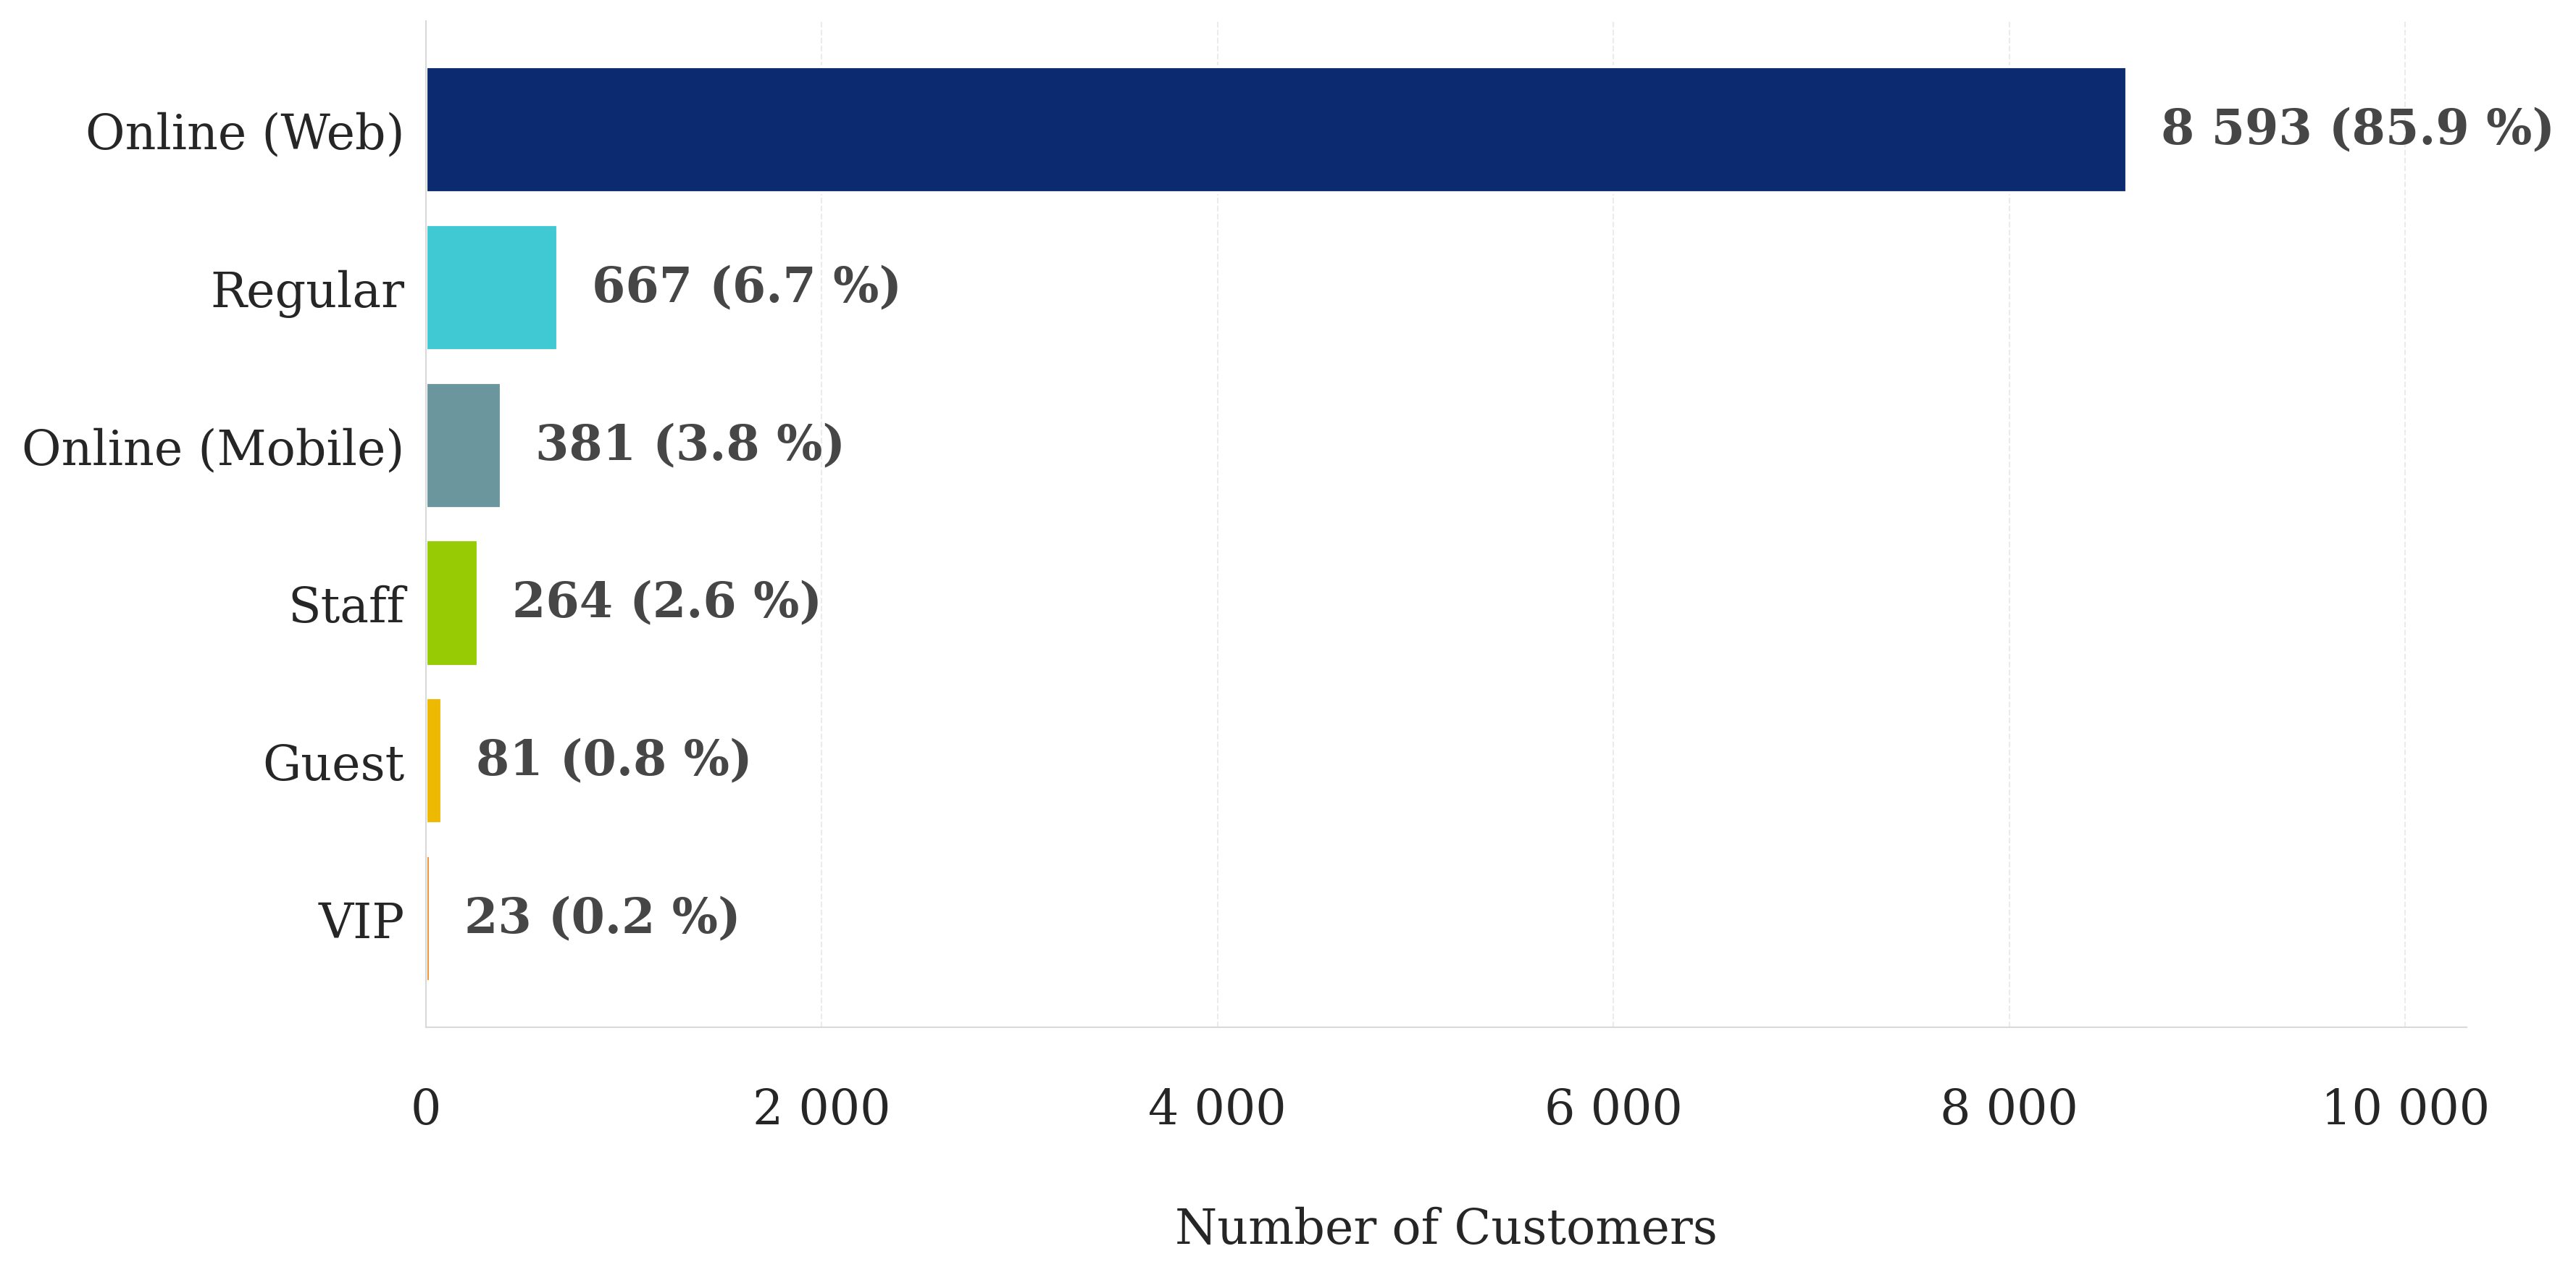

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read and prepare data
df = load_data("rq20-customer-distribution.csv")

# Calculate total for percentages
total = df['count'].sum()

# Sort
df = df.sort_values('count', ascending=True)

# Create type mapping for better labels
type_labels = {
	'Pass': 'Online (Web)',
	'iOS': 'Online (Mobile)',
	'Android': 'Android App',
	'POS': 'Regular',
	'POS VIP': 'VIP',
	'Staff': 'Staff',
	'Guest': 'Guest'
}

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Create y-positions
positions = np.arange(len(df))

# Plot horizontal bars
dflen = len(df)
bars = ax.barh(
	positions,
	df['count'],
	color=[get_chart_color(dflen - i - 1) for i in range(dflen)],
	zorder=2
)

# Add value labels
for i, count in enumerate(df['count']):
	percentage = (count / total) * 100
	ax.text(
		count + (df['count'].max() * 0.02),  # Adjust padding proportionally
		positions[i],
		f"{format_number(count, 0)} ({format_percent(percentage)})",
		va='center',
		fontsize=16,
		fontweight='bold',
		color=get_chart_color('text')
	)

# Customize axes
ax.set_yticks(positions)
ax.set_yticklabels([type_labels[t] for t in df['customer_type']], fontsize=16)
ax.set_xlabel('Number of Customers', fontsize=16, labelpad=24)

# Customize grid and spines
ax.grid(True, axis='x', linestyle='--', alpha=0.2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
x_max = df['count'].max()
ax.set_xlim(0, x_max * 1.2)  # Add 20% padding for labels
ax.tick_params(axis='x', which='major', labelsize=16, pad=16)

# Grid customization
ax.grid(axis='y', linestyle='--', alpha=0)
ax.grid(axis='x', linestyle='--', alpha=0.5)

# Format x-axis with thousands separator
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format_number(x, 0)))

# Adjust layout
plt.tight_layout()

plt.savefig(get_charts_dir("rq20-customer-distribution.png"), dpi=300, bbox_inches='tight', pad_inches=0.1)

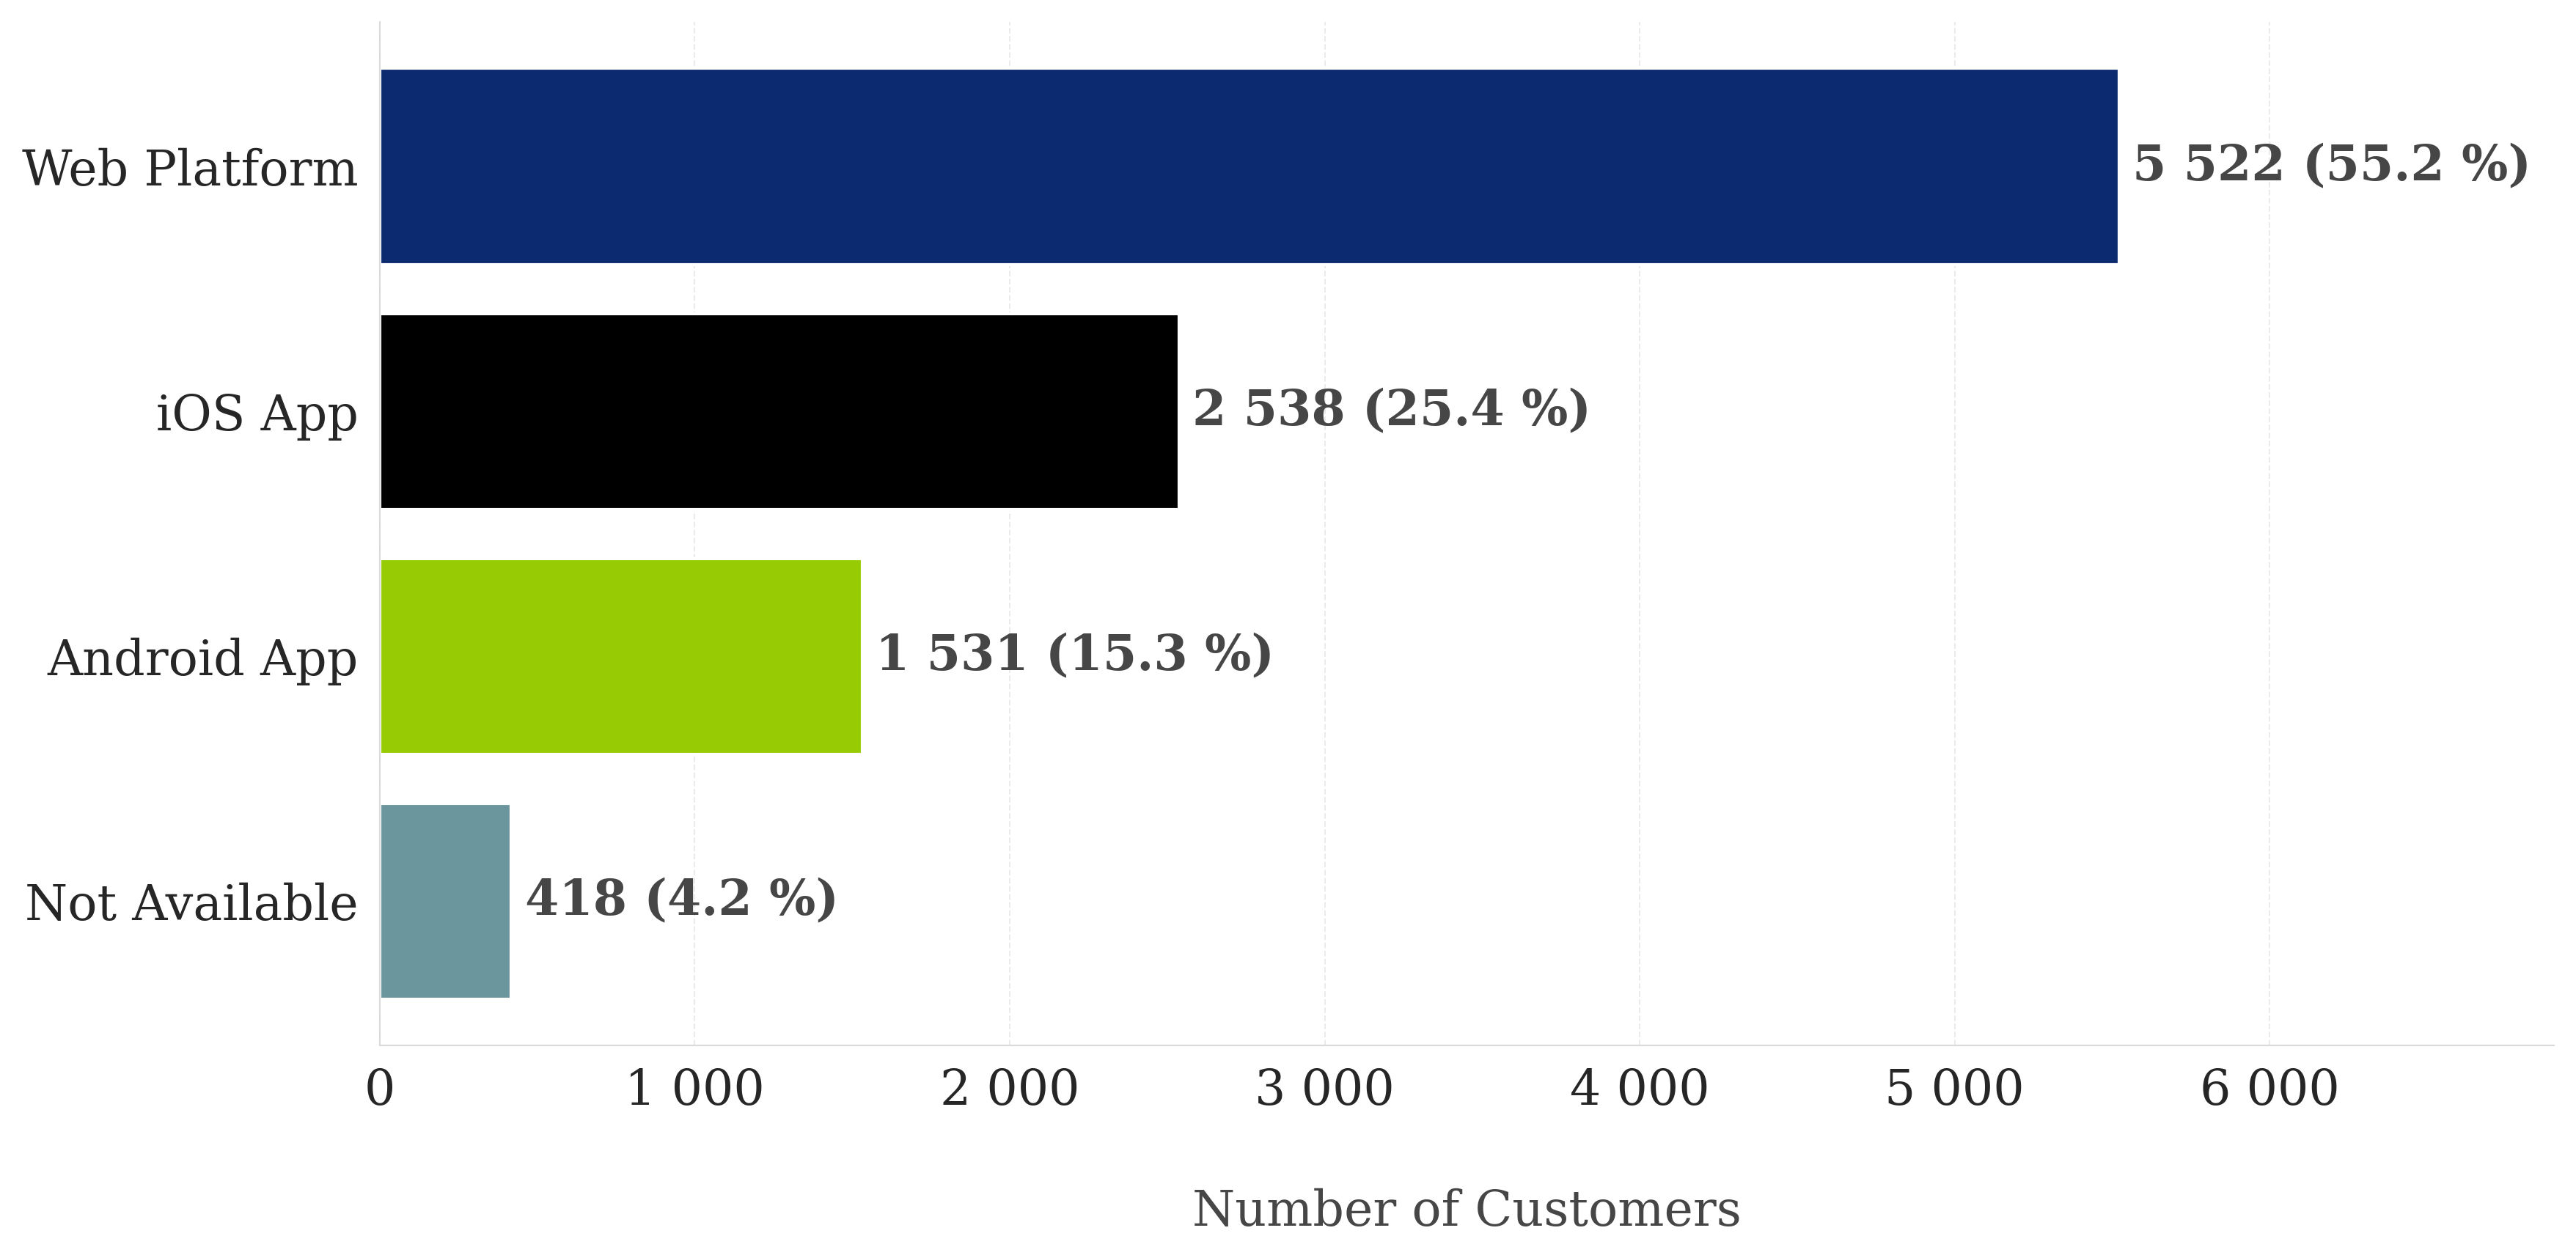

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read and prepare data
df = load_data("rq21-customer-app-usage.csv")
# Sort dataframe by count descending
df = df.sort_values('customer_count', ascending=False)

# Type mapping for better labels
category_config = {
	'Web': { 'color': get_chart_color(0), 'label': 'Web Platform' },
	'iOS': { 'color': '#000000', 'label': 'iOS App' },
	'Android': { 'color': get_chart_color(3), 'label': 'Android App' },
	'': { 'color': get_chart_color(2), 'label': 'Not Available' }
}


def get_config(row):
	return category_config[row['source']] if row['source'] in category_config else category_config['']


# Calculate total for percentages
total = df['customer_count'].sum()

# Create figure
fig, ax = plt.subplots(figsize=(12, 6))

# Create bars
bars = []
for i, (_, row) in enumerate(df[::-1].iterrows()):
	reversed_i = len(df) - i - 1  # Reverse order for better visualization
	bar = ax.barh(
		get_config(row)['label'],
		row['customer_count'],
		color=get_config(row)['color'],
	)
	bars.append(bar[0])

	# Add value labels
	width = row['customer_count']
	percentage = (width / total) * 100
	ax.text(
		width + 42,  # Slight padding
		bar[0].get_y() + bar[0].get_height() / 2,
		f"{format_number(width, 0)} ({format_percent(percentage)})",
		va='center',
		fontsize=16,
		color=get_chart_color('text'),
		fontweight='bold'
	)

# Customize chart
ax.set_xlabel('Number of Customers', fontsize=16, labelpad=24, color=get_chart_color('text'))
ax.tick_params(axis='both', labelsize=16)

# Format axis
ax.grid(True, axis='x', alpha=0.2)
ax.set_axisbelow(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# x-axis formatter
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format_number(x, 0)))

# Add padding to x-axis for labels
x_max = df['customer_count'].max()
ax.set_xlim(0, x_max * 1.25)

# hide grid y-axis
ax.grid(axis='y', linestyle='--', alpha=0)
ax.grid(axis='x', linestyle='--', alpha=0.5)

# Adjust layout
plt.tight_layout()

plt.savefig(get_charts_dir("rq21-customer-app-usage.png"), dpi=300, bbox_inches='tight', pad_inches=0.1)

In [ ]:
class BubbleChart:
	def __init__(self, area, bubble_spacing=0):
		"""
        Setup for bubble collapse.

        Parameters
        ----------
        area : array-like
            Area of the bubbles.
        bubble_spacing : float, default: 0
            Minimal spacing between bubbles after collapsing.

        Notes
        -----
        If "area" is sorted, the results might look weird.
        """
		area = np.asarray(area)
		r = np.sqrt(area / np.pi)

		self.bubble_spacing = bubble_spacing
		self.bubbles = np.ones((len(area), 4))
		self.bubbles[:, 2] = r
		self.bubbles[:, 3] = area
		self.maxstep = 2 * self.bubbles[:, 2].max() + self.bubble_spacing
		self.step_dist = self.maxstep / 2

		# calculate initial grid layout for bubbles
		length = np.ceil(np.sqrt(len(self.bubbles)))
		grid = np.arange(length) * self.maxstep
		gx, gy = np.meshgrid(grid, grid)
		self.bubbles[:, 0] = gx.flatten()[:len(self.bubbles)]
		self.bubbles[:, 1] = gy.flatten()[:len(self.bubbles)]

		self.com = self.center_of_mass()

	def center_of_mass(self):
		return np.average(
			self.bubbles[:, :2], axis=0, weights=self.bubbles[:, 3]
		)

	def center_distance(self, bubble, bubbles):
		return np.hypot(
			bubble[0] - bubbles[:, 0],
			bubble[1] - bubbles[:, 1]
		)

	def outline_distance(self, bubble, bubbles):
		center_distance = self.center_distance(bubble, bubbles)
		return center_distance - bubble[2] - \
			bubbles[:, 2] - self.bubble_spacing

	def check_collisions(self, bubble, bubbles):
		distance = self.outline_distance(bubble, bubbles)
		return len(distance[distance < 0])

	def collides_with(self, bubble, bubbles):
		distance = self.outline_distance(bubble, bubbles)
		return np.argmin(distance, keepdims=True)

	def collapse(self, n_iterations=50):
		"""
        Move bubbles to the center of mass.

        Parameters
        ----------
        n_iterations : int, default: 50
            Number of moves to perform.
        """
		for _i in range(n_iterations):
			moves = 0
			for i in range(len(self.bubbles)):
				rest_bub = np.delete(self.bubbles, i, 0)
				# try to move directly towards the center of mass
				# direction vector from bubble to the center of mass
				dir_vec = self.com - self.bubbles[i, :2]

				# shorten direction vector to have length of 1
				dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))

				# calculate new bubble position
				new_point = self.bubbles[i, :2] + dir_vec * self.step_dist
				new_bubble = np.append(new_point, self.bubbles[i, 2:4])

				# check whether new bubble collides with other bubbles
				if not self.check_collisions(new_bubble, rest_bub):
					self.bubbles[i, :] = new_bubble
					self.com = self.center_of_mass()
					moves += 1
				else:
					# try to move around a bubble that you collide with
					# find colliding bubble
					for colliding in self.collides_with(new_bubble, rest_bub):
						# calculate direction vector
						dir_vec = rest_bub[colliding, :2] - self.bubbles[i, :2]
						dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))
						# calculate orthogonal vector
						orth = np.array([dir_vec[1], -dir_vec[0]])
						# test which direction to go
						new_point1 = (self.bubbles[i, :2] + orth *
						              self.step_dist)
						new_point2 = (self.bubbles[i, :2] - orth *
						              self.step_dist)
						dist1 = self.center_distance(
							self.com, np.array([new_point1])
						)
						dist2 = self.center_distance(
							self.com, np.array([new_point2])
						)
						new_point = new_point1 if dist1 < dist2 else new_point2
						new_bubble = np.append(new_point, self.bubbles[i, 2:4])
						if not self.check_collisions(new_bubble, rest_bub):
							self.bubbles[i, :] = new_bubble
							self.com = self.center_of_mass()

			if moves / len(self.bubbles) < 0.1:
				self.step_dist = self.step_dist / 2

	def plot(self, ax, labels, colors):
		"""
        Draw the bubble plot.

        Parameters
        ----------
        ax : matplotlib.axes.Axes
        labels : list
            Labels of the bubbles.
        colors : list
            Colors of the bubbles.
        """
		for i in range(len(self.bubbles)):
			circ = plt.Circle(
				self.bubbles[i, :2], self.bubbles[i, 2], color=colors[i]
			)
			ax.add_patch(circ)

# ax.text(
#     *self.bubbles[i, :2], labels[i],
#     horizontalalignment='center', verticalalignment='center',
#     fontsize=14
# )

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define your data
df = load_data("rq1-total-revenue-breakdown.csv")
grouped_data = df.groupby('grouped').apply(lambda g: g.nlargest(5, 'value', 'all')).reset_index(drop=True)

# Normalize Sizes for Bubble Chart
max_bubble_size = 15000  # Adjust for scaling
max_value = grouped_data['value'].max()
grouped_data['size'] = grouped_data['value'] / max_value * max_bubble_size

# Define colors for each bubble
grouped_colors = {
	"commission": get_chart_color(2),
	"unclaimed_balance": get_chart_color(3),
	"ticket_sales": get_chart_color(1),
	"direct_sales": get_chart_color(0),
}
colors = [grouped_colors[group] for group in grouped_data['grouped']]


# Function to truncate labels
def truncate_label(label, max_length=16):
	if len(label) > max_length:
		return label[:max_length - 3] + "…"
	return label


# Adjust labels based on bubble size
labels = []
for _, row in grouped_data.iterrows():
	size = row['size']
	category = row['category']
	labels.append("")

# Load data and process it
bubble_chart = BubbleChart(grouped_data['size'], bubble_spacing=1)
bubble_chart.collapse()

# Plot the chart
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw=dict(aspect="equal"))
bubble_chart.plot(ax, labels, colors)

# Add labels manually
for i, (x, y, r) in enumerate(bubble_chart.bubbles[:, :3]):
	size = grouped_data.loc[i, 'size']
	category = grouped_data.loc[i, 'category']

	# Determine label visibility and text
	if size > 3000:  # Larger bubbles show full labels
		label = truncate_label(category, max_length=16)
		font_size = 16 if size > 5000 else 14  # Adjust font size based on bubble size
		ax.text(
			x, y, label,
			ha="center", va="center",
			fontsize=font_size, fontname="serif", color="white"
		)
	elif size > 1000:  # Medium bubbles show truncated labels
		label = truncate_label(category, max_length=8)
		ax.text(
			x, y, label,
			ha="center", va="center",
			fontsize=10, fontname="serif", color="white"
		)
	elif size > 200:
		# label = truncate_label(category, max_length=6)
		label = ''
		ax.text(
			x, y, label,
			ha="center", va="center",
			fontsize=10, fontname="serif", color="white"
		)

# Styling
ax.axis('off')  # Hide axes
ax.relim()
ax.autoscale_view()
plt.tight_layout()

plt.savefig(get_charts_dir("rq1-total-revenue-breakdown.png"), dpi=300, bbox_inches='tight', pad_inches=0.1)

/var/folders/c3/2hv96b893plc4w_ptghflx840000gn/T/ipykernel_92888/140863792.py:63: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(category_sales.index, fontsize=14)


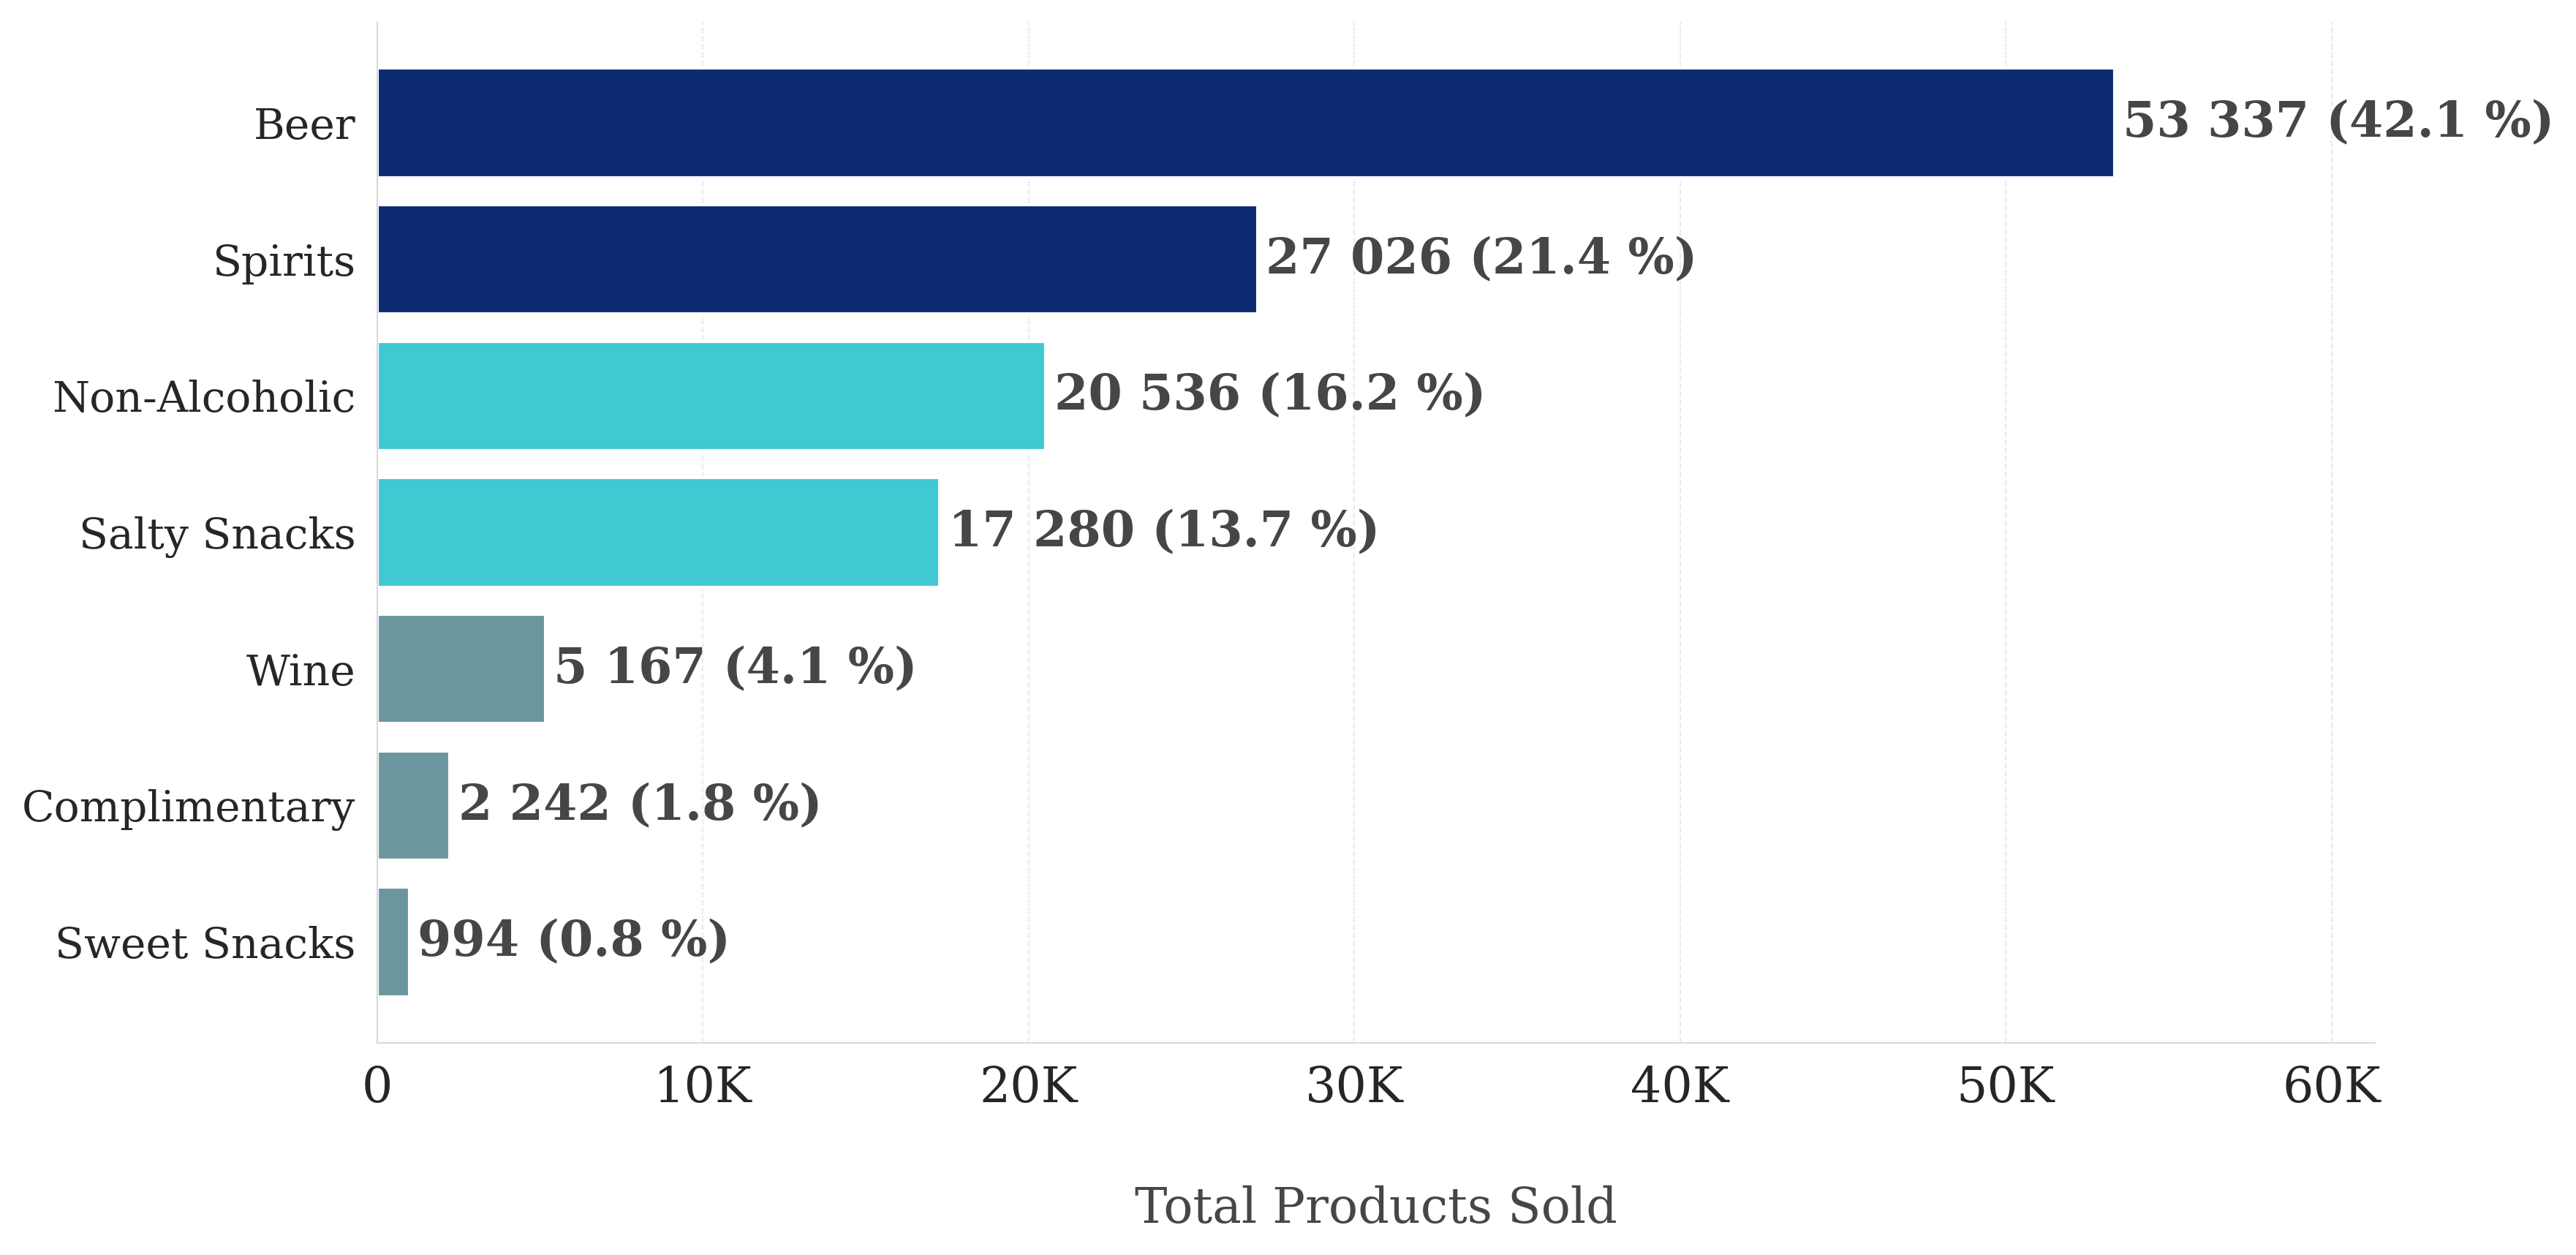

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read and prepare data
df = load_data("rq11-best-product-category.csv")

# Group by category and calculate mean sales
category_sales = df.groupby('category')['sales_count'].mean().sort_values(ascending=True)

# Create figure
fig, ax = plt.subplots(figsize=(12, 6))

# Type mapping for better labels
category_config = {
	# 'Web': { 'color': get_chart_color(0), 'label': 'Web Platform' },
	'Beer': { 'color': get_chart_color(0) },
	'Spirits': { 'color': get_chart_color(0) },
	'Wine': { 'color': get_chart_color(2) },
	'Non-Alcoholic': { 'color': get_chart_color(1) },
	'Salty Snacks': { 'color': get_chart_color(1) },
	'Sweet Snacks': { 'color': get_chart_color(2) },
	'Complimentary': { 'color': get_chart_color(2) },
}

# Create horizontal bars
bars = []
for i, (cat, value) in enumerate(category_sales.items()):
	conf = category_config[cat]
	bar = ax.barh(
		cat,
		value,
		color=conf['color']
	)
	bars.append(bar[0])

	# Add value labels
	ax.text(
		value + 250,  # Slight padding
		bar[0].get_y() + bar[0].get_height() / 2,
		f"{format_number(value, 0)} ({format_percent(value / category_sales.sum() * 100)})",
		va='center',
		fontsize=16,
		color=get_chart_color('text'),
		fontweight='bold'
	)

# Customize chart
ax.set_xlabel('Total Products Sold', fontsize=16, labelpad=24, color=get_chart_color('text'))
ax.tick_params(axis='both', labelsize=16)

# x-tick formatter
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: format_number_short(x)))

# Format axis
ax.grid(True, axis='x', alpha=0.2)
ax.set_axisbelow(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Format y-axis labels
ax.set_yticklabels(category_sales.index, fontsize=14)

# Add padding to x-axis for labels
x_max = category_sales.max()
ax.set_xlim(0, x_max * 1.15)  # Add 15% padding for labels

# hide grid y-axis
ax.grid(axis='y', linestyle='--', alpha=0)
ax.grid(axis='x', linestyle='--', alpha=0.5)

# Adjust layout
plt.tight_layout()

plt.savefig(get_charts_dir("rq11-best-product-category.png"), dpi=300, bbox_inches='tight', pad_inches=0.1)

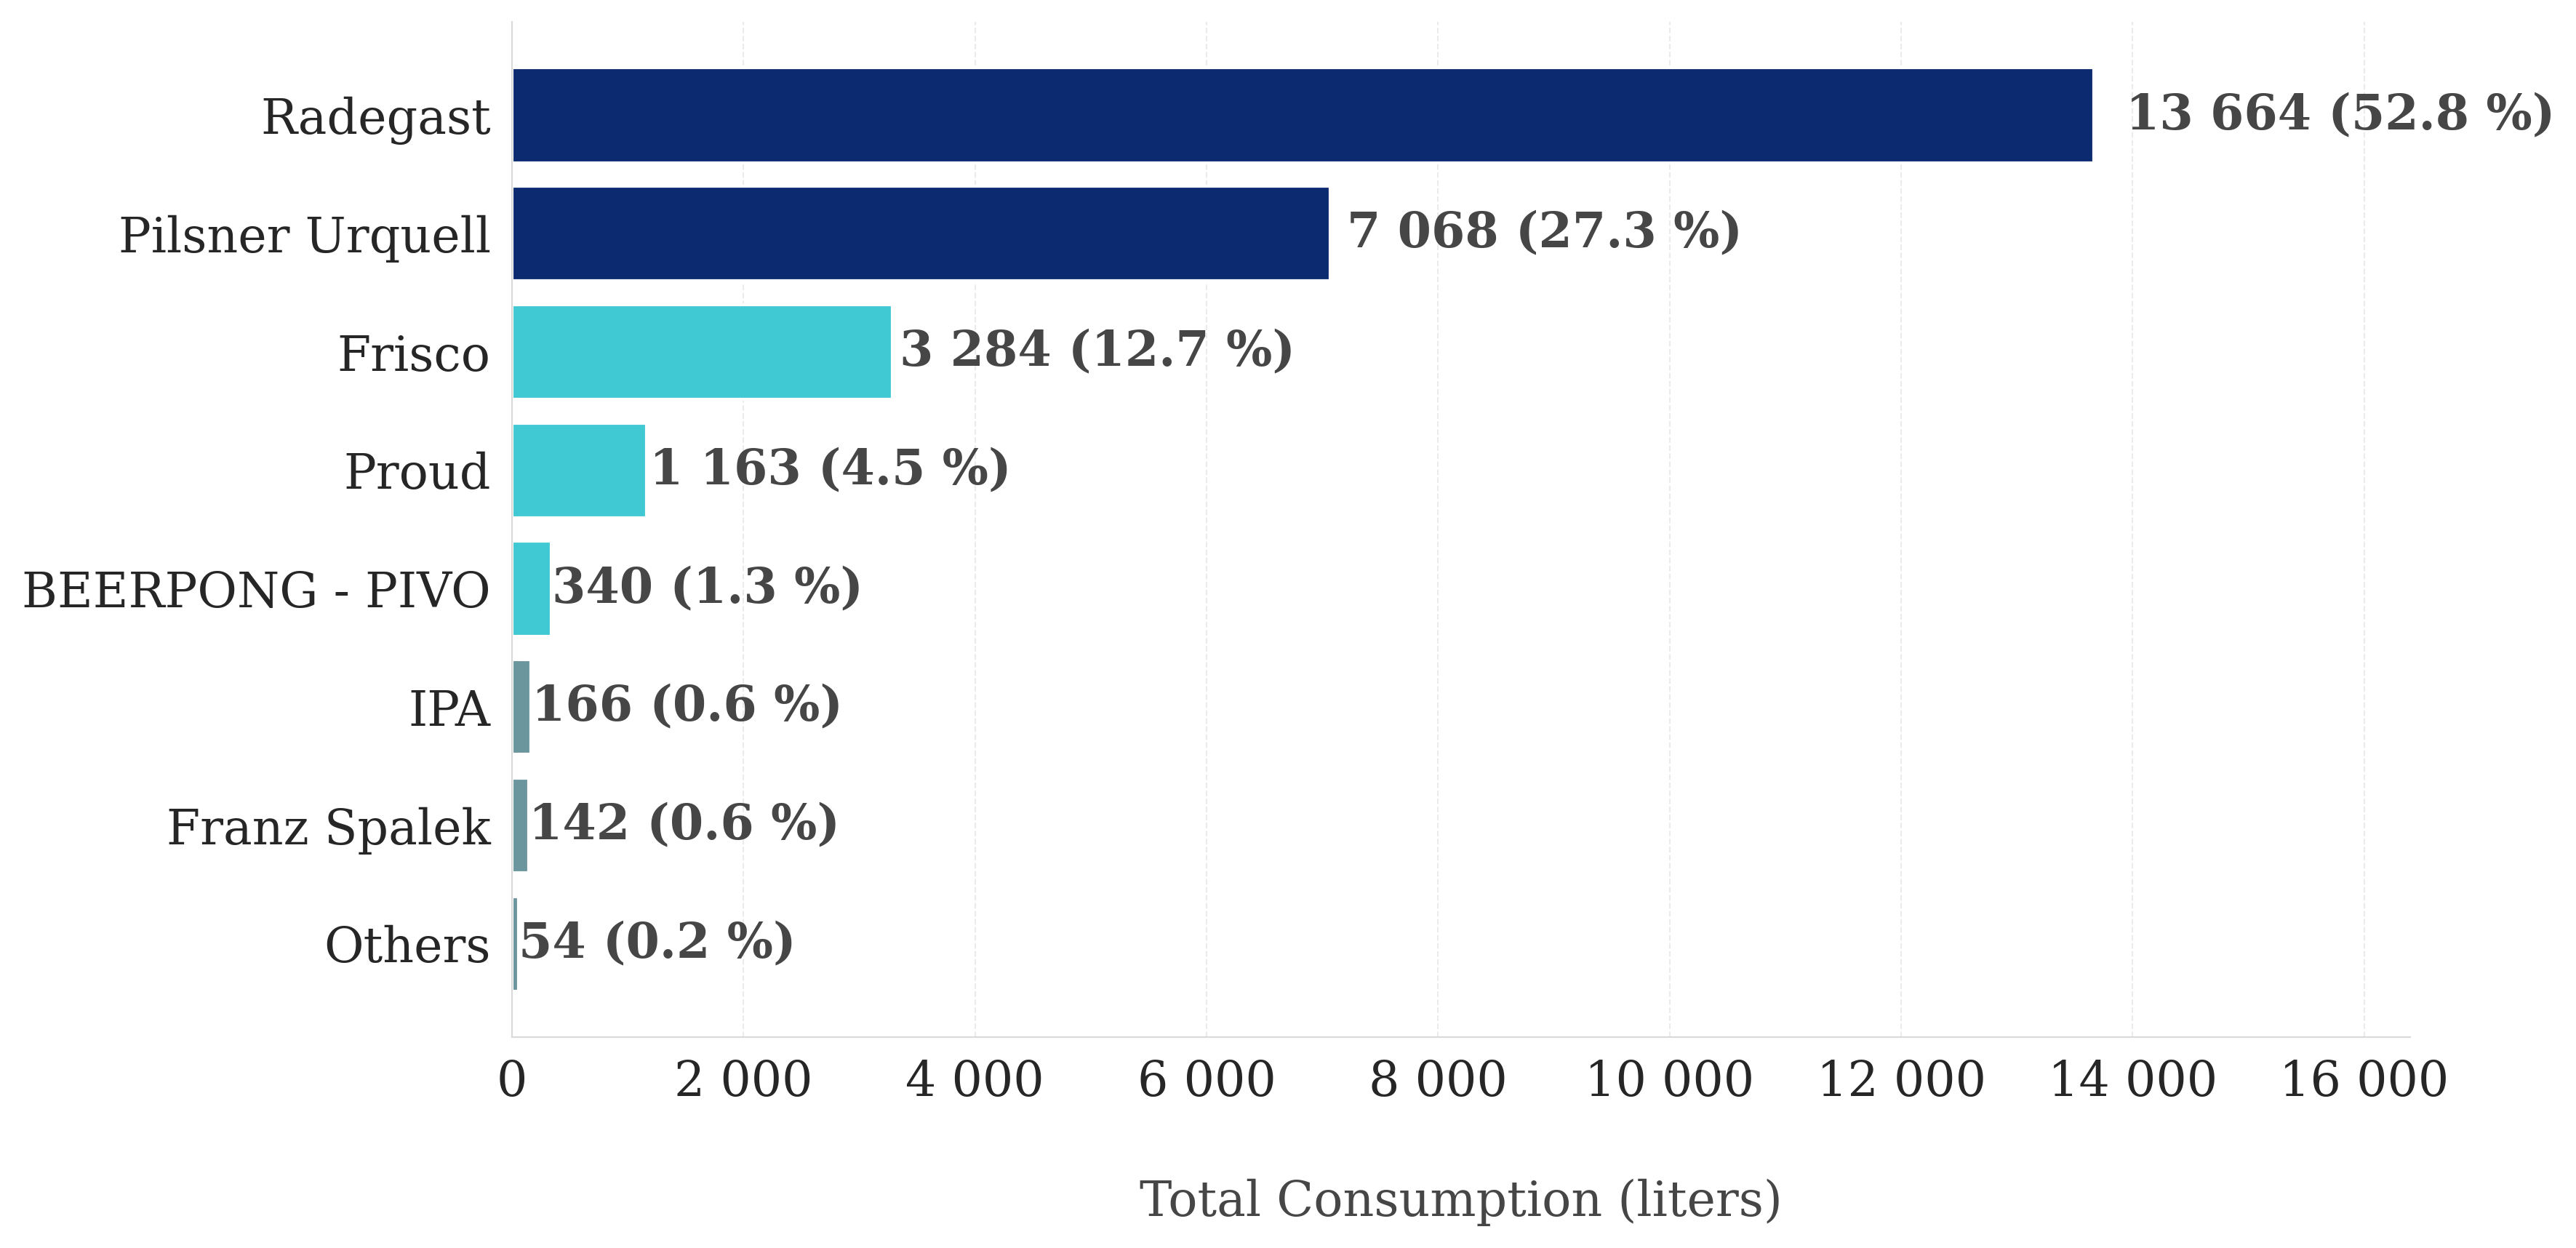

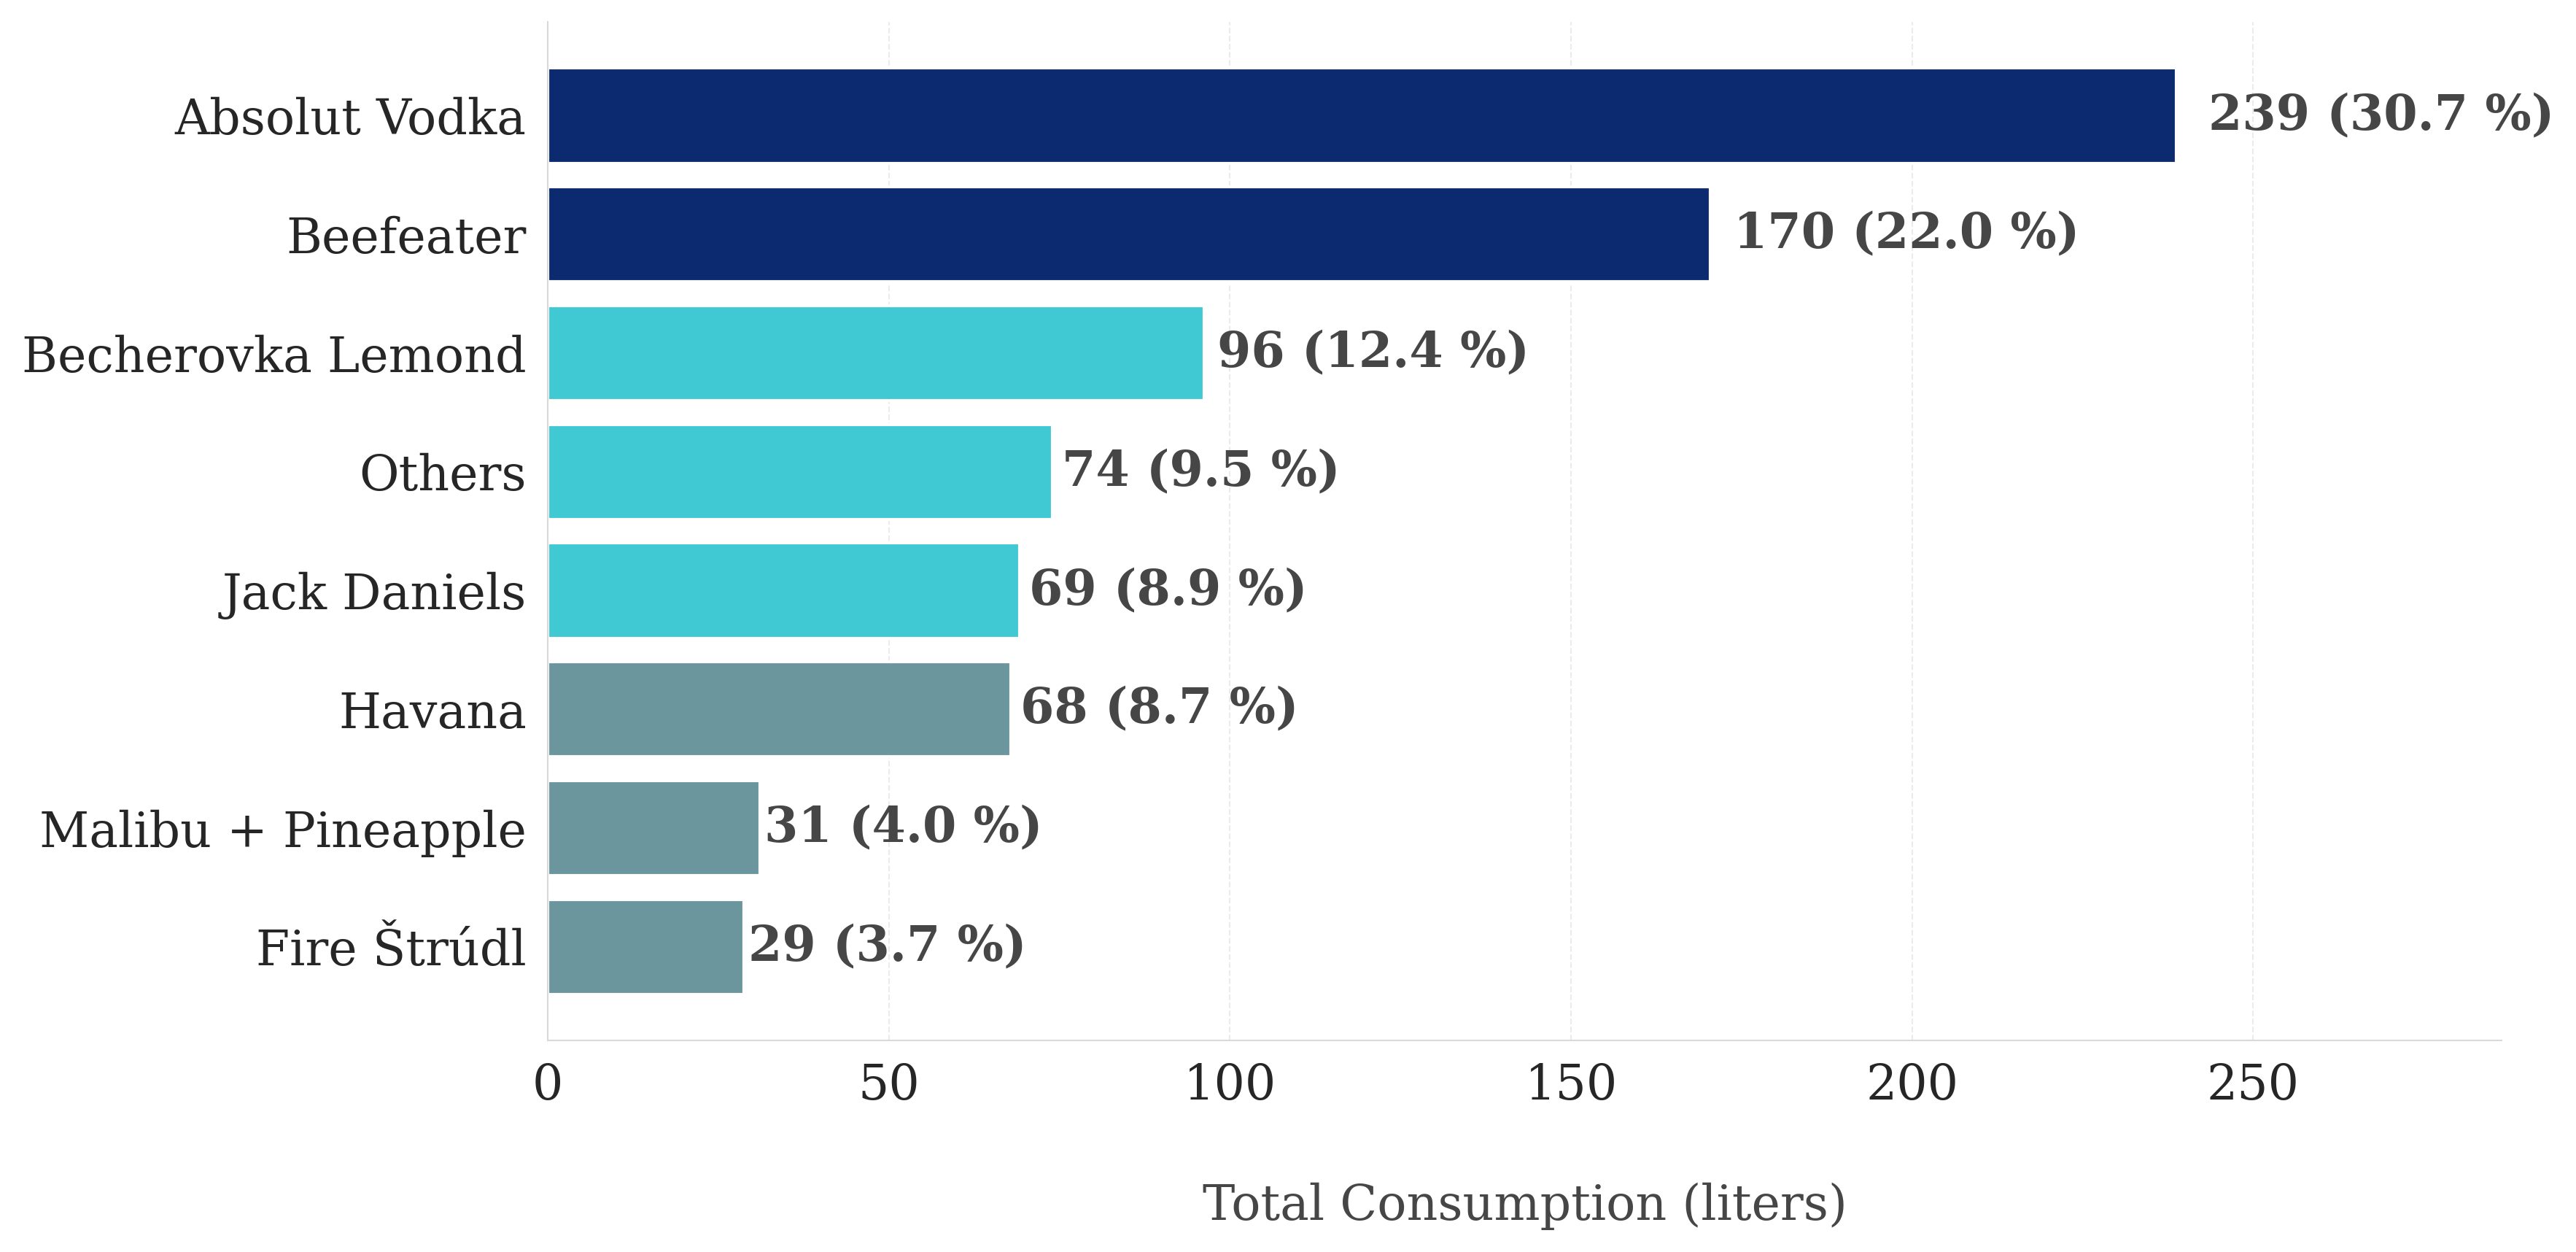

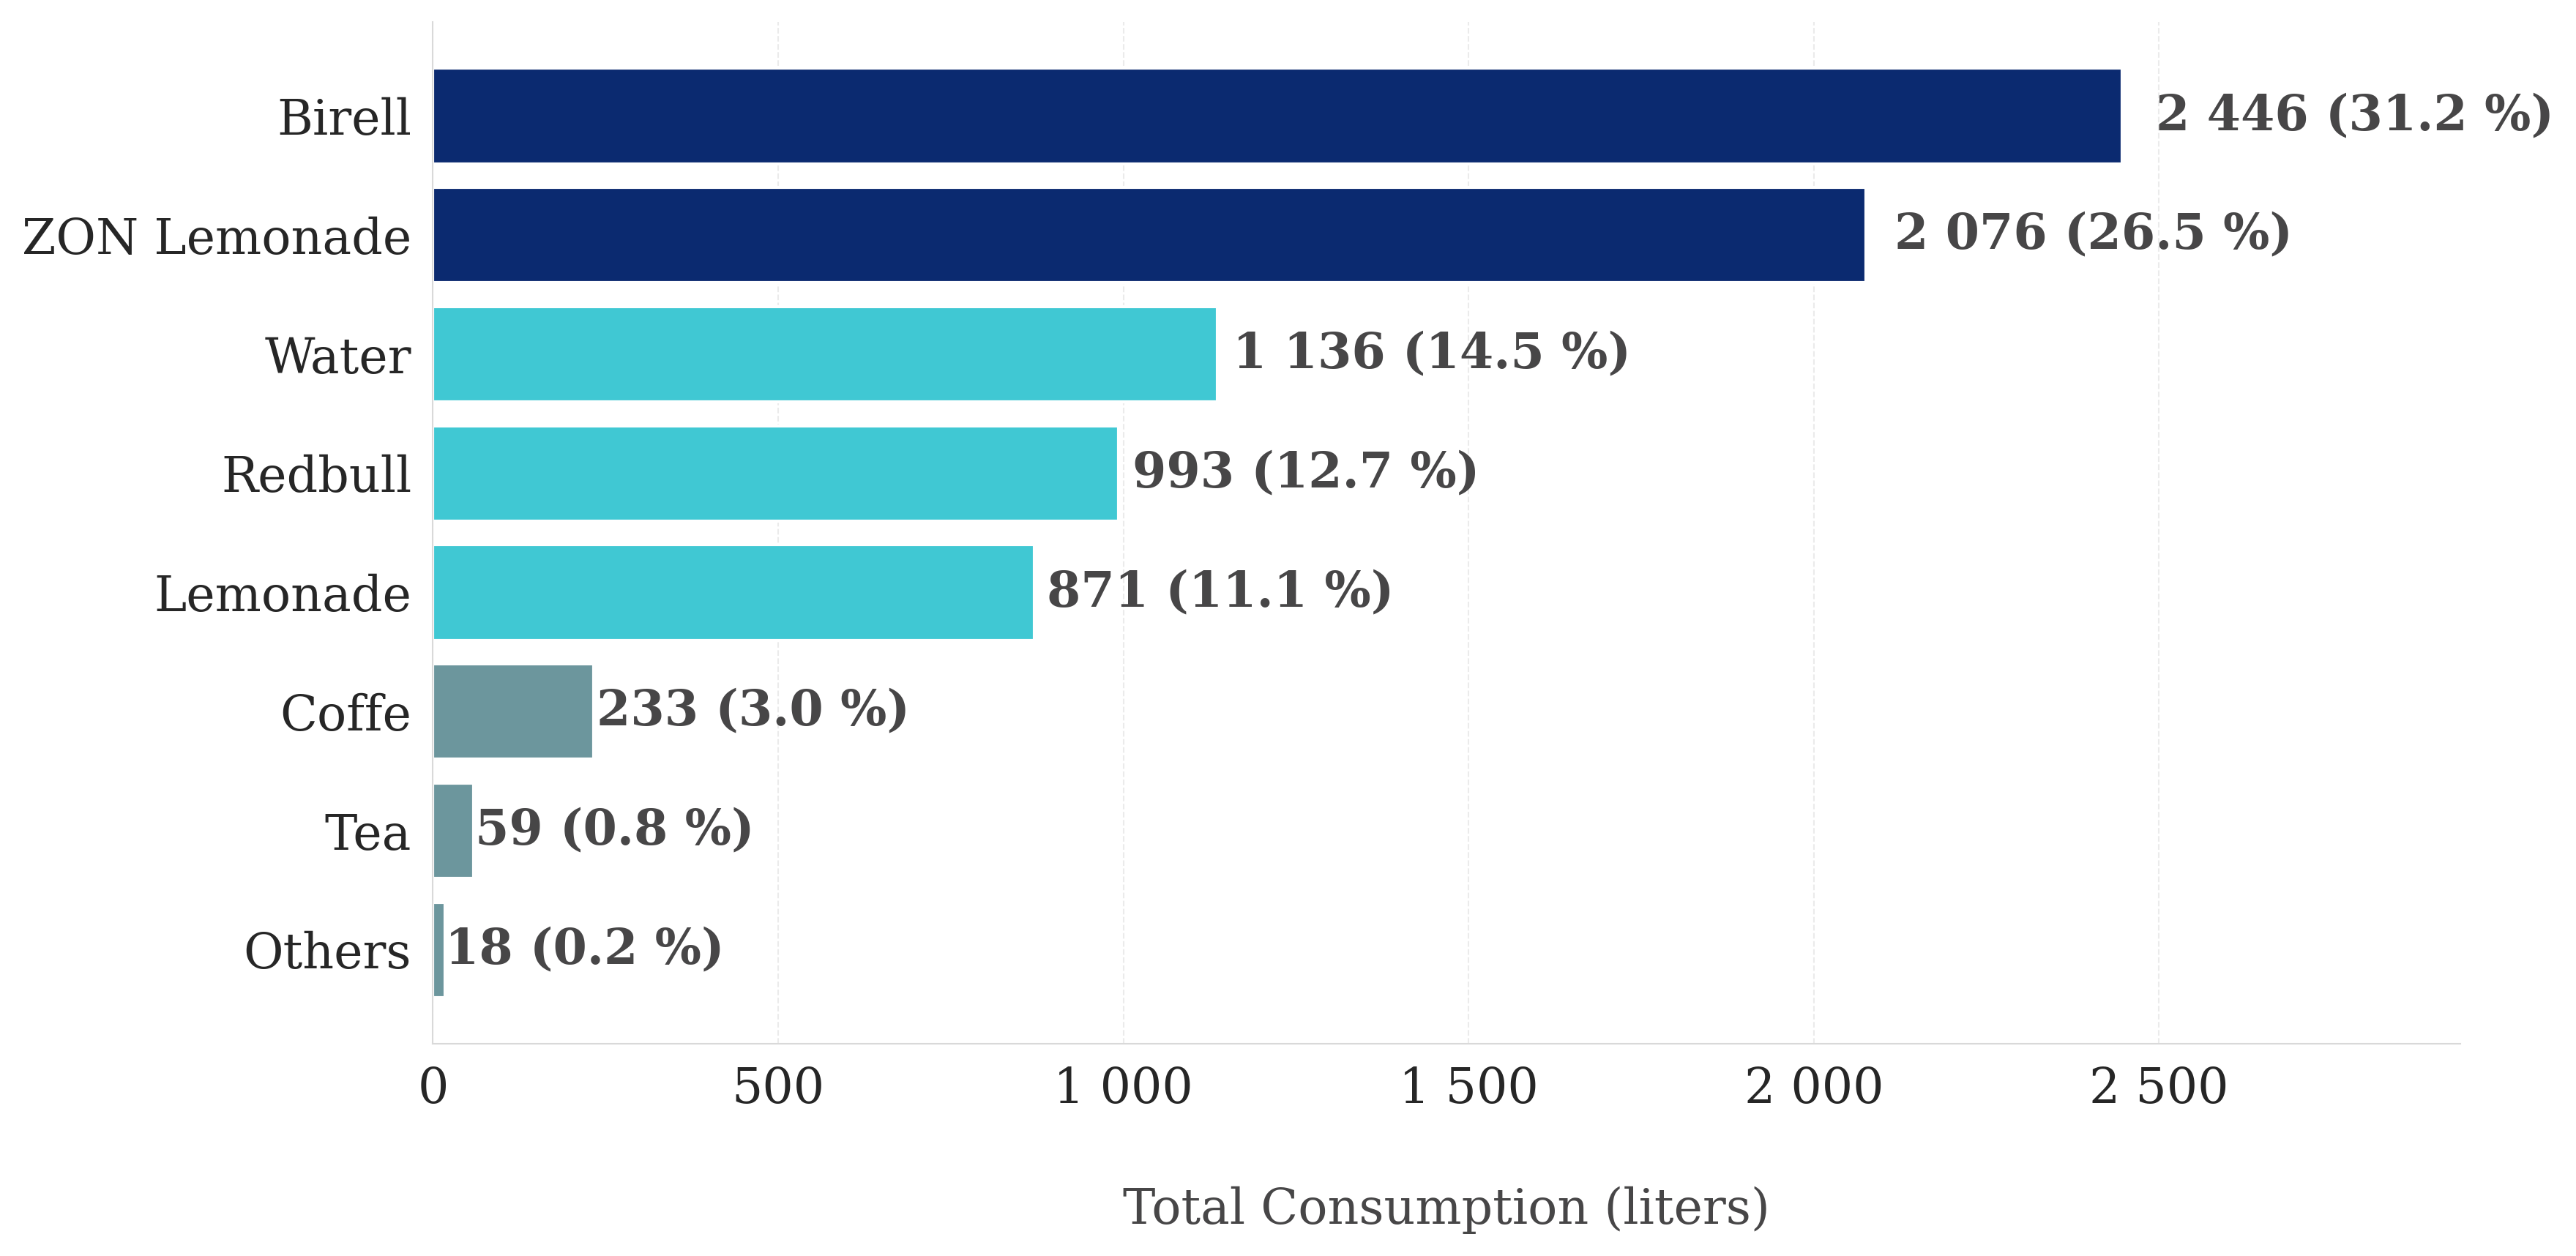

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import ticker


# Read and prepare data
def plot_bev_chart(df):
	# Sort by consumption
	# take only 10 first rows, and merge the rest into 'Others'
	top_10 = df.nlargest(7, 'total_consumption_liters')
	others = df.nsmallest(len(df) - 7, 'total_consumption_liters').sum()
	if (others['total_consumption_liters'] > 0):
		others['subcategory'] = 'Others'
		df = pd.concat([top_10, pd.DataFrame(others).T])
	df = df.sort_values('total_consumption_liters', ascending=True)
	df = df.reset_index(drop=True)

	total_sum = df['total_consumption_liters'].sum()

	# Create figure
	fig, ax = plt.subplots(figsize=(12, 6))

	# Create horizontal bars
	bars = []
	for i, row in df.iterrows():
		colors = [2, 2, 2, 1, 1, 1, 0, 0]
		bar = ax.barh(
			row['subcategory'],
			row['total_consumption_liters'],
			color=get_chart_color(colors[i] if i < len(colors) else 2)
		)
		bars.append(bar[0])

		# Add value labels
		ax.text(
			row['total_consumption_liters'] * 1.02,
			bar[0].get_y() + bar[0].get_height() / 2,
			# format_volume(row["total_consumption_liters"] * 1000),
			f"{format_number(row['total_consumption_liters'], 0)} ({format_percent(row['total_consumption_liters'] / total_sum * 100)})",
			va='center',
			fontsize=16,
			color=get_chart_color('text'),
			fontweight='bold'
		)

	# Customize chart
	ax.set_xlabel('Total Consumption (liters)', fontsize=16, labelpad=24, color=get_chart_color('text'))
	ax.tick_params(axis='both', labelsize=16)

	# x-tick formatter
	ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{format_number(x)}"))

	# Format axis
	ax.grid(True, axis='x', alpha=0.2)
	ax.set_axisbelow(True)
	ax.spines['top'].set_visible(False)
	ax.spines['right'].set_visible(False)

	# Add padding to x-axis for labels
	x_max = df['total_consumption_liters'].max()
	ax.set_xlim(0, x_max * 1.2)  # Add 15% padding for labels

	# hide grid y-axis
	ax.grid(axis='y', linestyle='--', alpha=0)
	ax.grid(axis='x', linestyle='--', alpha=0.5)

	# Adjust layout
	plt.tight_layout()

	# Save the figure
	return plt


beer_chart = plot_bev_chart(load_data("rq15-top-beer-brands.csv"))
beer_chart.savefig(get_charts_dir("rq15-top-beer-brands.png"), dpi=300, bbox_inches='tight', pad_inches=0.1)
beer_chart.show()

alco_chart = plot_bev_chart(load_data("rq16-top-alco-brands.csv"))
alco_chart.savefig(get_charts_dir("rq16-top-alco-brands.png"), dpi=300, bbox_inches='tight', pad_inches=0.1)
alco_chart.show()

non_alco_chart = plot_bev_chart(load_data("rq17-top-non-alco-brands.csv"))
non_alco_chart.savefig(get_charts_dir("rq17-top-non-alco-brands.png"), dpi=300, bbox_inches='tight', pad_inches=0.1)
non_alco_chart.show()


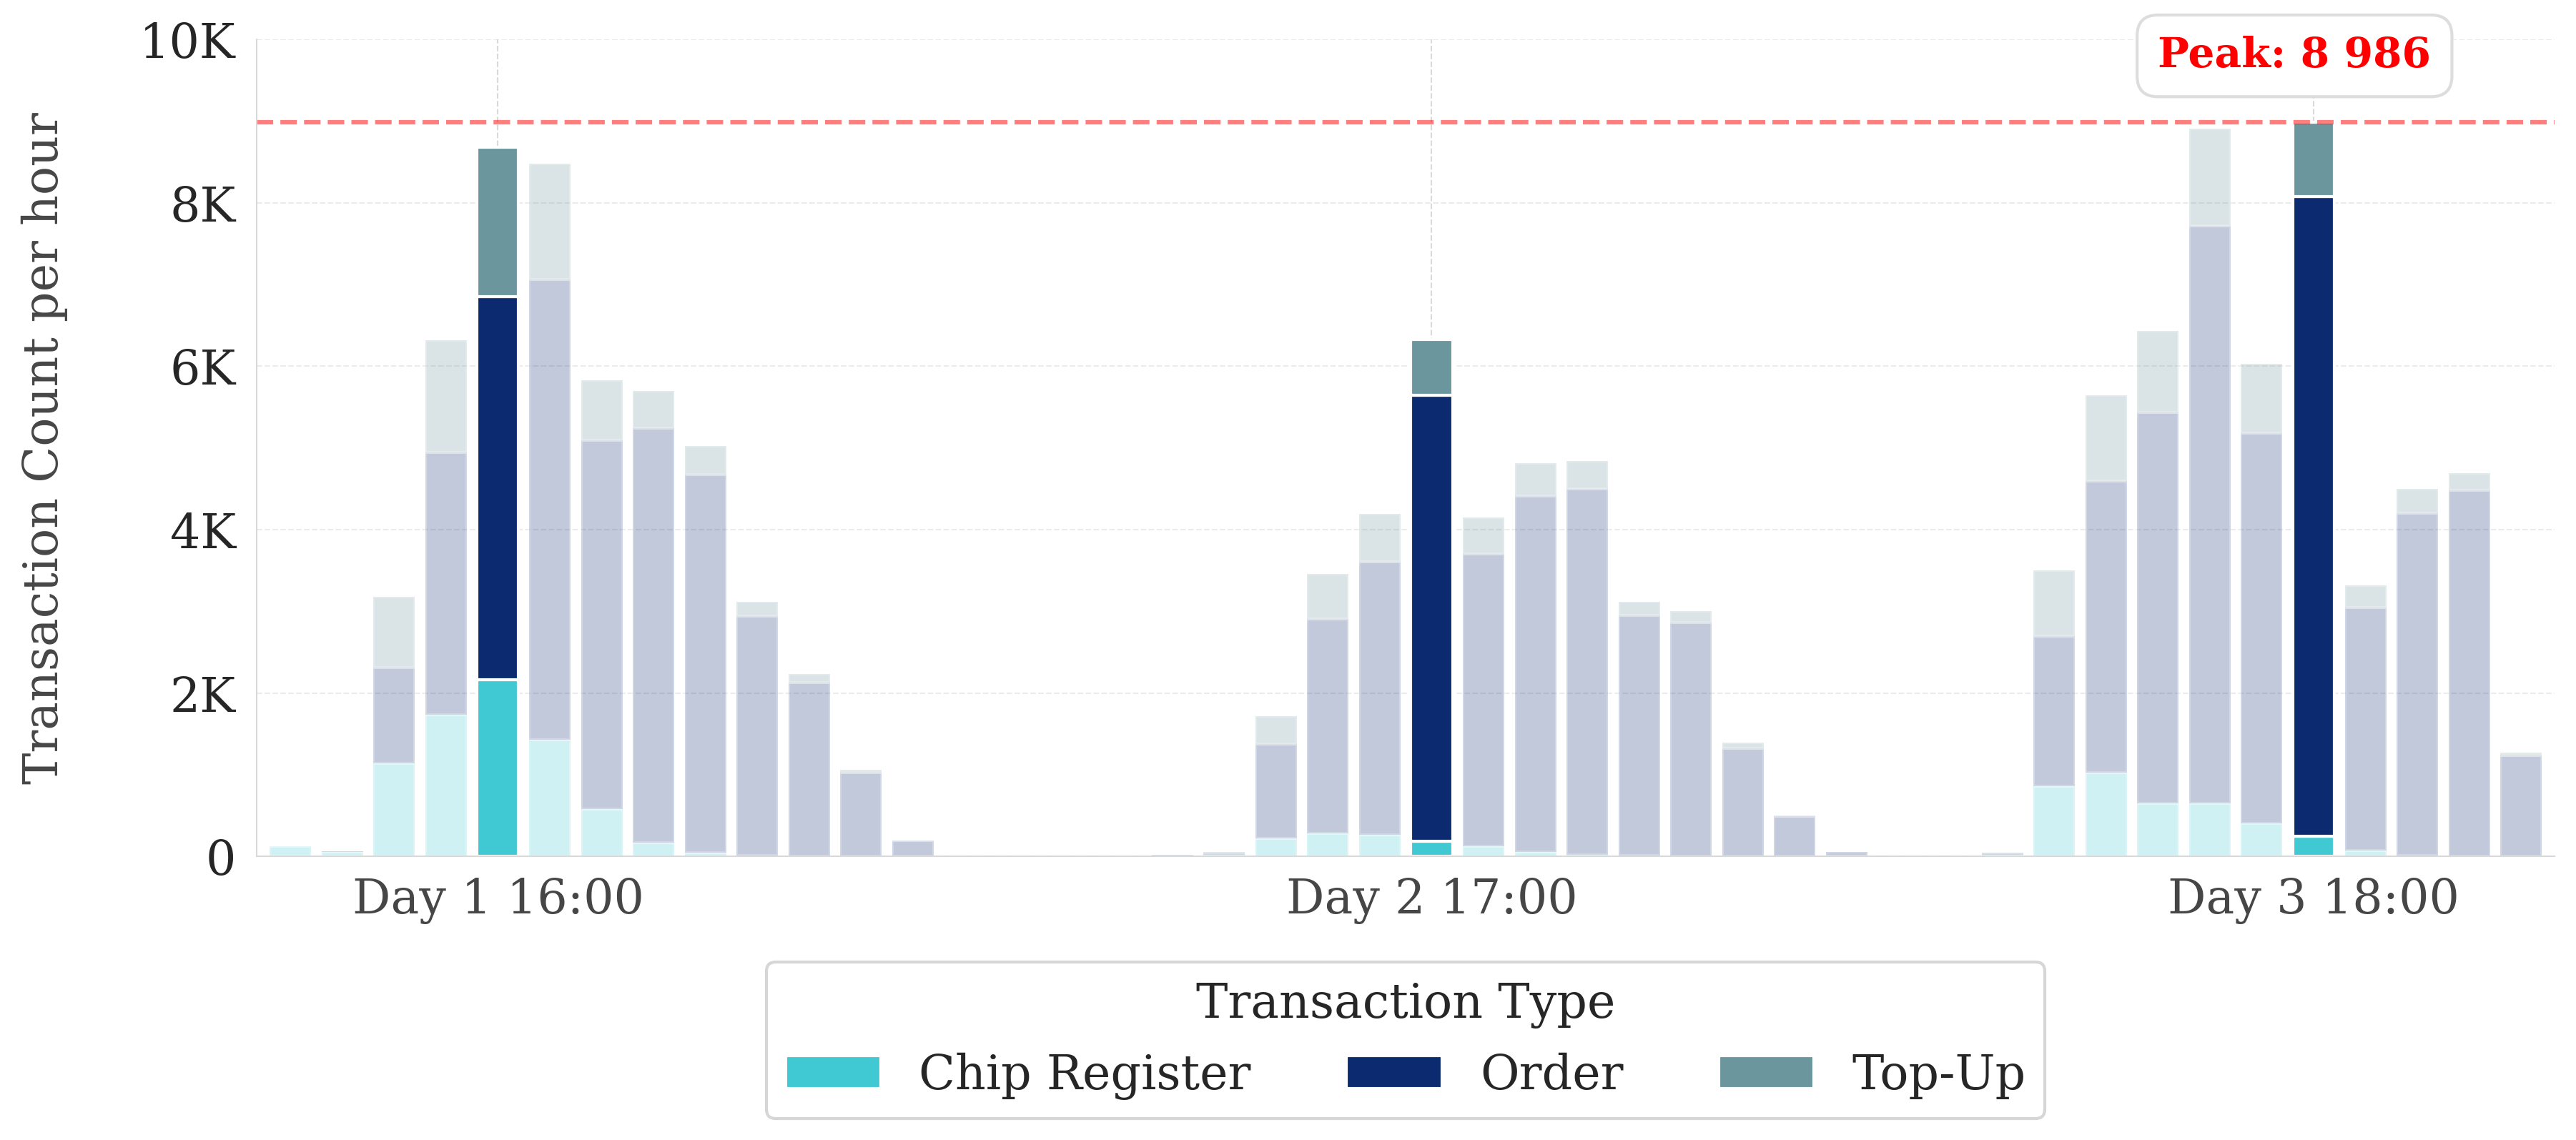

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import ticker

# Read and prepare data
df = load_data("rq6-transaction-peaks.csv")
df['hour'] = pd.to_datetime(df['day'])

# Label mappings
type_labels = {
	'chip_register': 'Chip Register',
	'order': 'Order',
	'topup': 'Top-Up'
}

# Pivot the data for stacking
df_pivot = df.pivot(index='hour', columns='type', values='count').fillna(0)
df_pivot.columns = [type_labels[col] for col in df_pivot.columns]

# Create figure
fig, ax = plt.subplots(figsize=(12, 6))

# Create stacked bars
colors = {
	'Chip Register': get_chart_color(1),
	'Order': get_chart_color(0),
	'Top-Up': get_chart_color(2)
}

# Plot stacked bars with lower opacity for all bars
bars = df_pivot.plot(
	kind='bar',
	stacked=True,
	ax=ax,
	color=[colors[col] for col in df_pivot.columns],
	alpha=0.25,
	width=0.8
)

# Define peak times and values
peaks = {
	pd.to_datetime("2024-07-04 16:00"): 8477,
	pd.to_datetime("2024-07-05 17:00"): 6330,
	pd.to_datetime("2024-07-06 18:00"): 8986,
}

# Add peak lines and annotations
limited_peaks = dict(sorted(peaks.items(), key=lambda item: item[1], reverse=True)[:1])
for peak_time, peak_value in limited_peaks.items():
	ax.axhline(y=peak_value, color='red', linestyle='--', alpha=0.5)
	ax.text(
		36,
		peak_value * 1.075,
		f'Peak: {format_number(peak_value)}',
		color='red',
		fontsize=14,
		fontweight='bold',
		bbox=dict(
			boxstyle="round,pad=0.5",
			fc="white",
			ec="#DDDDDD",
		)
	)

# Make peak bars full opacity
for peak_time in peaks.keys():
	if peak_time in df_pivot.index:
		peak_idx = df_pivot.index.get_loc(peak_time)
		for container in ax.containers:
			container[peak_idx].set_alpha(1.0)

# Customize chart
ax.set_ylabel('Transaction Count per hour', fontsize=16, labelpad=24, color=get_chart_color('text'))
ax.set_xlabel('')
ax.tick_params(axis='both', labelsize=16)

# Format x-axis with highlighted peaks
tick_interval = 6
# xticks = np.arange(0, len(df_pivot.index), step=tick_interval)
xticks = np.arange(0, 0)

# Add peak times to xticks if not already included
for peak_time in peaks.keys():
	if peak_time in df_pivot.index:
		peak_idx = df_pivot.index.get_loc(peak_time)
		if peak_idx not in xticks:
			xticks = np.sort(np.append(xticks, peak_idx))

ax.set_xticks(xticks)
tick_labels = [format_event_datetime(df_pivot.index[i]) for i in xticks]
ax.set_xticklabels(
	tick_labels,
	rotation=60,
	ha='center',
	fontsize=14
)

# Color the peak tick labels red
for i, tick in enumerate(ax.get_xticklabels()):
	tick_datetime = df_pivot.index[xticks[i]]
	if tick_datetime in peaks:
		tick.set_color(get_chart_color('text'))
		tick.set_fontsize(16)
		tick.set_rotation(0)
	else:
		tick.set_color('white')

# Format y-axis
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format_number_short(x)))

# Add gridlines
ax.grid(True, axis='y', alpha=0.5)
ax.set_axisbelow(True)

# Remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Create custom legend elements with full opacity
legend_elements = [
	plt.Rectangle(
		(0, 0),
		1,
		1,
		facecolor=colors[label],
		alpha=1.0,  # Full opacity for legend
		label=label
	) for label in df_pivot.columns
]

# Add legend with custom elements
ax.legend(
	handles=legend_elements,
	loc='upper center',
	bbox_to_anchor=(0.5, -0.1),
	ncol=len(df_pivot.columns),
	fontsize=16,
	title='Transaction Type',
	title_fontsize=16
)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])

# set y-lim
ax.set_ylim(0, 10000)

# Save the figure
plt.savefig(get_charts_dir("rq5-transaction-peaks.png"), dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

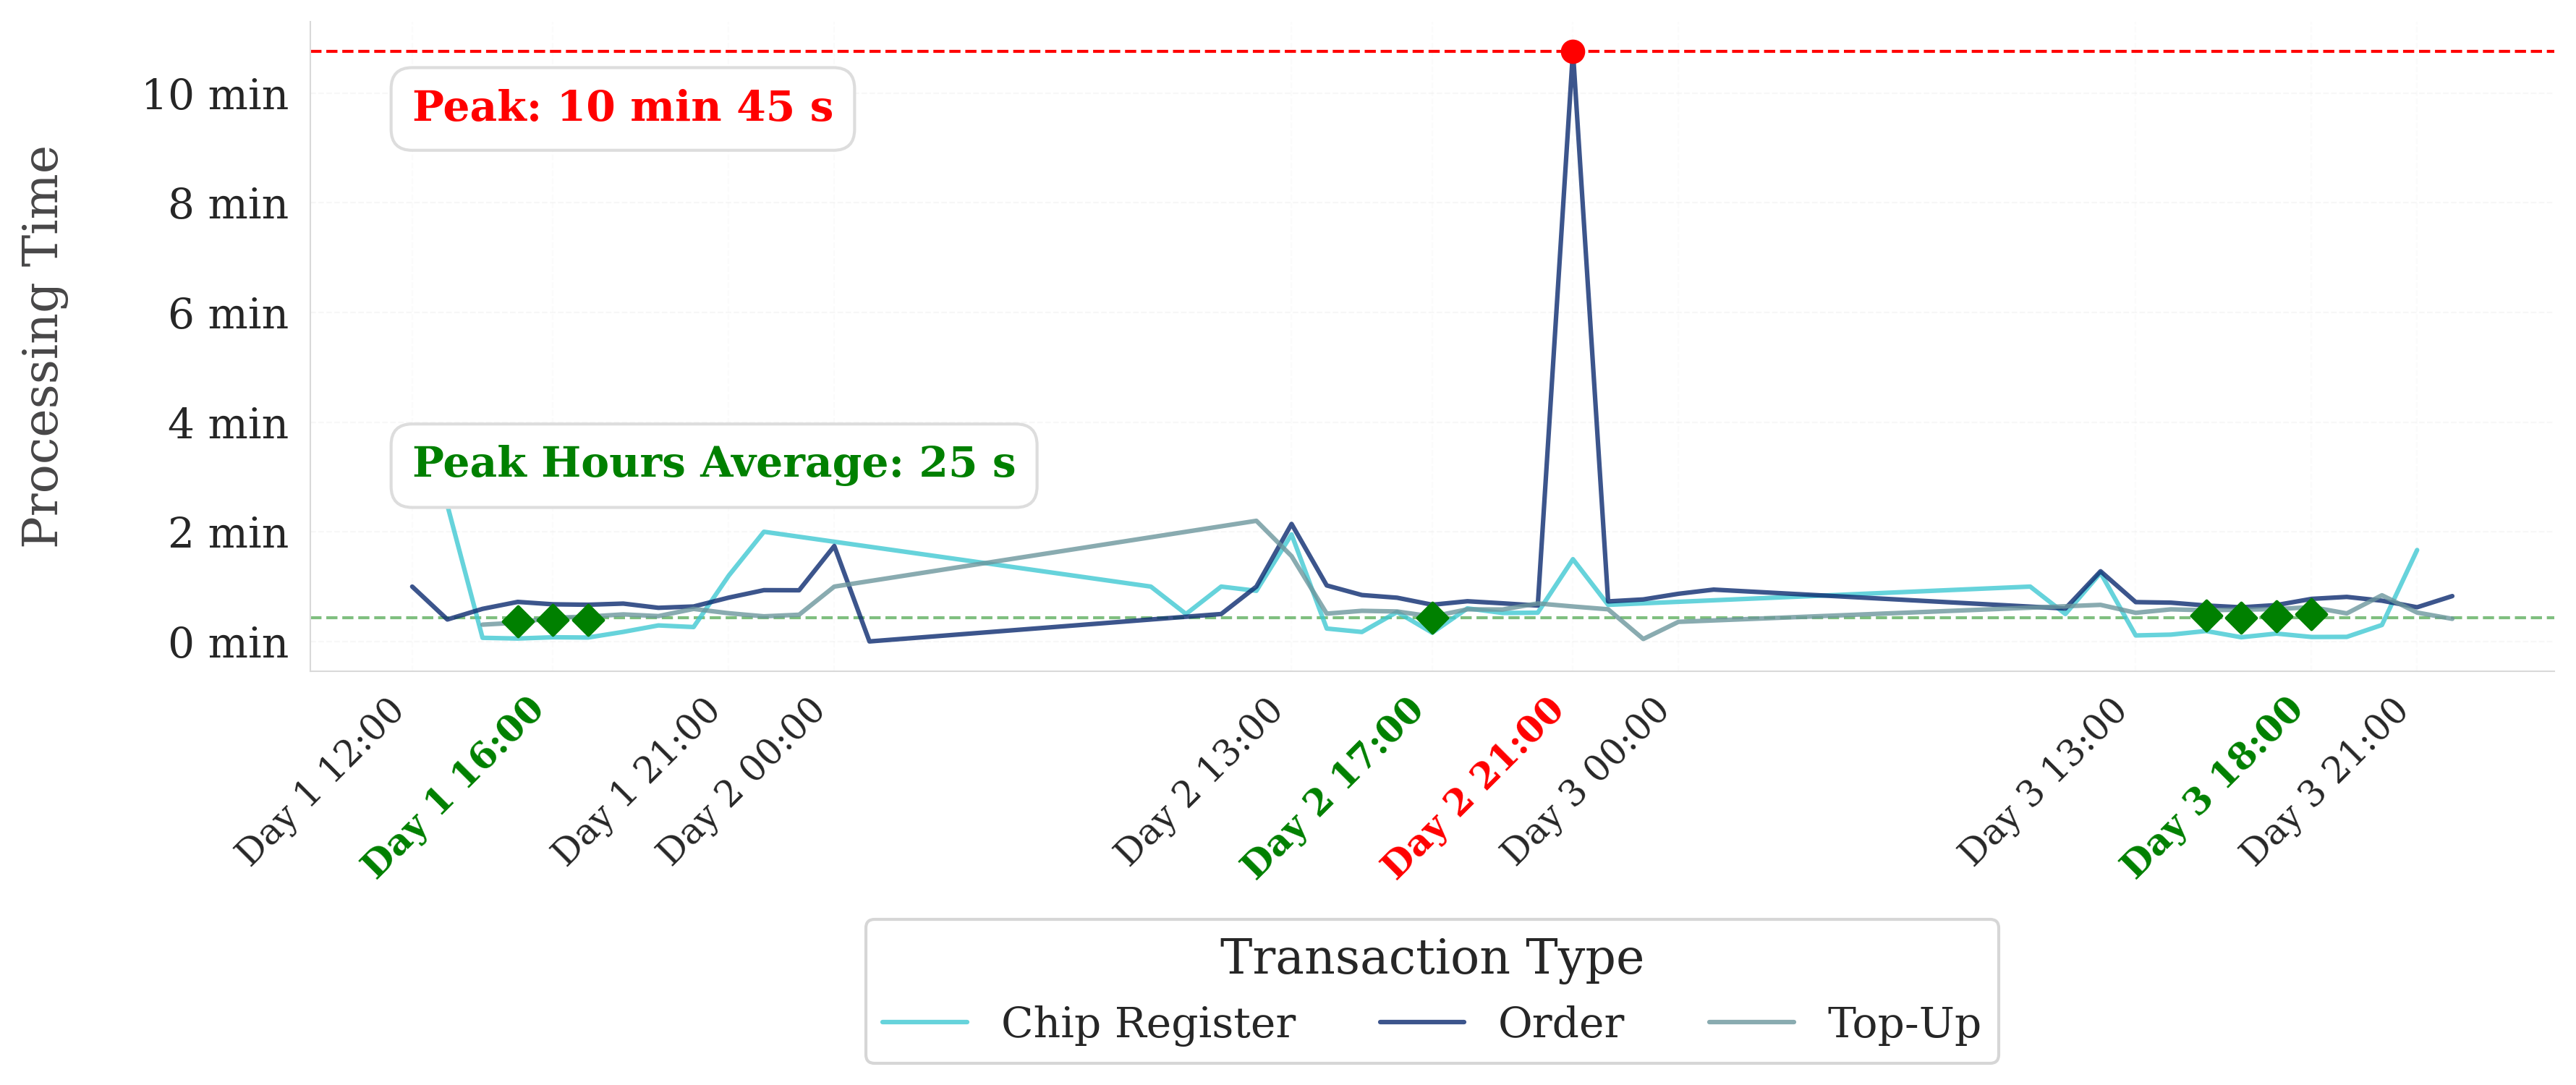

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import ticker
import matplotlib.dates as mdates

# Read and prepare data
df = load_data("rq6-transaction-peaks.csv")
df['hour'] = pd.to_datetime(df['day'])

# Define selected dates (peak hours)
selected_dates = [
	pd.to_datetime("2024-07-04 15:00"),
	pd.to_datetime("2024-07-04 16:00"),
	pd.to_datetime("2024-07-04 17:00"),
	pd.to_datetime("2024-07-05 17:00"),
	pd.to_datetime("2024-07-06 15:00"),
	pd.to_datetime("2024-07-06 16:00"),
	pd.to_datetime("2024-07-06 17:00"),
	pd.to_datetime("2024-07-06 18:00"),
]

# Calculate average for selected dates
selected_data = df[df['hour'].isin(selected_dates)]
selected_avg = selected_data['avg_processing_time'].mean()

# Label mappings and colors
type_config = {
	'chip_register': { 'label': 'Chip Register', 'color': get_chart_color(1) },
	'order': { 'label': 'Order', 'color': get_chart_color(0) },
	'topup': { 'label': 'Top-Up', 'color': get_chart_color(2) }
}

# Create figure with more height for better readability
fig, ax = plt.subplots(figsize=(12, 6))

# Plot lines for each transaction type
for type_original, config in type_config.items():
	type_data = df[df['type'] == type_original].copy()
	type_data = type_data.sort_values('hour')

	ax.plot(
		type_data['hour'],
		type_data['avg_processing_time'],
		label=config['label'],
		color=config['color'],
		alpha=0.8,
		linewidth=1.5  # Slightly thicker lines
	)

# Find peak
peak_mask = df['avg_processing_time'] == df['avg_processing_time'].max()
peak_data = df[peak_mask].iloc[0]
peak_time = peak_data['hour']
peak_value = peak_data['avg_processing_time']

# Calculate average
avg_value = df['avg_processing_time'].mean()

# Add peak line and annotation
ax.axhline(y=peak_value, color='#ff0000', linestyle='--', alpha=1, zorder=1, linewidth=1)

# Create background for text annotations
peak_text = f"Peak: {format_duration(peak_value)}"
avg_text = f"Average: {format_duration(avg_value)}"

# Add text annotations with white background for better readability
bbox_props = dict(
	boxstyle="round,pad=0.5",
	fc="white",
	ec="#DDDDDD",
)

ax.text(
	df['hour'].min(),
	9.5,
	peak_text,
	color='red',
	fontsize=14,
	fontweight='bold',
	bbox=bbox_props
)

# Position average text below peak text to avoid overlap
# ax.text(
# 	df['hour'].min(),
# 	avg_value * 0.85,  # Position below the line
# 	avg_text,
# 	color='gray',
# 	fontsize=14,
# 	bbox=bbox_props
# )

# Add dashed line for average
# ax.axhline(y=avg_value, color='gray', linestyle='--', alpha=0.3, zorder=1)

# Add dashed line for selected dates average
ax.axhline(y=selected_avg, color='green', linestyle='--', alpha=0.5, zorder=1, linewidth=1)

# Add text annotation for selected dates average
selected_avg_text = f"Peak Hours Average: {format_duration(selected_avg)}"
ax.text(
	df['hour'].min(),
	3,
	selected_avg_text,
	color='green',
	fontsize=14,
	fontweight='bold',
	bbox=bbox_props
)

# Customize chart
ax.set_ylabel('Processing Time', fontsize=16, labelpad=24, color=get_chart_color('text'))
ax.tick_params(axis='both', labelsize=14)

# Set custom ticks
custom_ticks = [
	pd.to_datetime("2024-07-04 12:00"),
	pd.to_datetime("2024-07-04 16:00"),
	pd.to_datetime("2024-07-04 21:00"),
	pd.to_datetime("2024-07-05 00:00"),
	pd.to_datetime("2024-07-05 13:00"),
	pd.to_datetime("2024-07-05 17:00"),
	pd.to_datetime("2024-07-05 21:00"),
	pd.to_datetime("2024-07-06 00:00"),
	pd.to_datetime("2024-07-06 13:00"),
	pd.to_datetime("2024-07-06 18:00"),
	pd.to_datetime("2024-07-06 21:00")
]
ax.set_xticks(custom_ticks)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format_event_datetime(x)))

# Rotate and align x-axis labels
plt.xticks(rotation=45, ha='right', fontsize=12)

# Highlight selected dates with markers
for date in selected_dates:
	date_data = df[df['hour'] == date]
	if not date_data.empty:
		# Calculate mean processing time across all transaction types for this date
		mean_processing_time = date_data['avg_processing_time'].mean()
		ax.scatter(
			date,  # We can use the date directly since it's already a datetime
			mean_processing_time,
			color='green',
			s=50,
			alpha=1,
			zorder=4,
			marker='D'  # Diamond marker to distinguish from peak marker
		)

# Modify x-axis tick labels to highlight selected dates
for tick in ax.get_xticklabels():
	tick_time = mdates.num2date(tick.get_position()[0])
	if tick_time.strftime('%Y-%m-%d %H:00') in [date.strftime('%Y-%m-%d %H:00') for date in selected_dates]:
		tick.set_color('green')
		tick.set_fontweight('bold')
	elif tick_time.strftime('%Y-%m-%d %H:00') == peak_time.strftime('%Y-%m-%d %H:00'):
		tick.set_color('#ff0000')
		tick.set_fontweight('bold')
		ax.scatter(tick_time, peak_value, color='#ff0000', s=50, alpha=1, zorder=3)

# Format y-axis with more readable intervals
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format_duration(x)))

# Enhance gridlines
ax.grid(True, axis='y', linestyle='--', alpha=0.2)
ax.grid(True, axis='x', linestyle='--', alpha=0.1)
ax.set_axisbelow(True)

# Remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add legend with improved positioning and style
legend = ax.legend(
	loc='upper center',
	bbox_to_anchor=(0.5, -0.35),
	ncol=len(type_config),
	fontsize=14,
	frameon=True,
	title='Transaction Type',
	title_fontsize=16,
	edgecolor='#cccccc'
)

# Adjust layout with more space for legend
plt.tight_layout(rect=[0, 0.1, 1, 1.05])

# Save the figure
plt.savefig(get_charts_dir("rq7-processing-times.png"), dpi=300, bbox_inches='tight', pad_inches=0.1)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
labels = ['Issued', 'Returned', 'Not Returned']
values = [22045, 17322, 4723]
colors = [
	get_chart_color(0),
	get_chart_color(1),
	get_chart_color(2),
]  # Blue, Green, Red

# Create figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Calculate bottom positions for each bar
bottom_positions = [0, values[0] - values[1], 0]

# Plot bars
bars = []
for i in range(len(values)):
	bar = ax.bar(
		labels[i],  # X-axis label
		values[i],  # Bar height
		color=colors[i],  # Bar color
		width=0.5,  # Bar width
		bottom=bottom_positions[i],  # Start position
		align='center'
	)
	bars.append(bar[0])

# Add text labels to bars
for i, bar in enumerate(bars):
	height = bar.get_height()
	percentage = (height / values[0]) * 100

	# Add formatted labels
	ax.text(
		bar.get_x() + bar.get_width() / 2,
		bottom_positions[i] + height + 2000,
		f"{format_number(height)} ({format_percent(percentage)})",
		ha='center', va='center',
		fontsize=16, fontweight='bold', color=get_chart_color('text')
	)

# Add connecting lines
ax.plot(
	[-0.25, 1.25], [values[0], values[0]], 'k:', alpha=0.15
)
ax.plot(
	[0.75, 2.25], [bottom_positions[1], bottom_positions[1]], 'k:', alpha=0.15
)

# Customize the plot
ax.set_ylabel('Number of Cups', fontsize=16, labelpad=20)
ax.set_ylim(0, sum(values) + 2000)
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, fontsize=16)

# Format y-axis with thousands separator
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format_number_short(x)))
ax.tick_params(axis='y', labelsize=16)

# Add legend below the chart with a box
ax.legend(
	bars,
	labels,
	loc='upper center',
	bbox_to_anchor=(0.5, -0.1),
	fontsize=14,
	ncol=3,
	frameon=True,  # Add box around legend
	edgecolor='#cccccc'
)

# Add box with return rate in a nice box centered top
return_rate = (values[1] / values[0]) * 100
return_rate_text = f'Return Rate: {format_percent(return_rate)}'
ax.text(
	1, 27500,
	return_rate_text,
	fontsize=16,
	color=get_chart_color('text'),
	ha='center',
	fontweight="bold",
	bbox=dict(
		boxstyle='round,pad=0.5',
		fc='white',
		ec='#cccccc'
	)
)

# set y-axis range 0 to 30000
plt.ylim(0, 30000)

# Remove unnecessary spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.savefig(get_charts_dir("rq13-returnable-cups.png"), dpi=300, bbox_inches='tight', pad_inches=0.1)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the provided data
data = load_data("rq9-best-topup-points.csv")

# Sort the data for better visualization (by Transactions)
data = data.sort_values(by="transaction_count", ascending=False)

# Define colors for better distinction
colors = ['#2563EB' if "Pokladna" in x else '#22C55E' if "Odbavení" in x else '#EF4444' for x in data["entity"]]

# Create a grouped bar chart
x = np.arange(len(data))  # the label locations
bar_width = 0.8

fig, ax = plt.subplots(figsize=(14, 8))

# Bar plots for each metric
# bar1 = ax.bar(x - bar_width, data['customer_count'], bar_width, label='Customers', color='#1D4ED8', alpha=0.8)
bar2 = ax.bar(x, data['transaction_count'], bar_width, label='Transactions', color=get_chart_color(2))
# bar3 = ax.bar(x + bar_width, data['max_hourly_peak'], bar_width, label='Max Transactions/Hour', color='#93C5FD', alpha=0.8)

# Add labels on the bars
show_max = 3
# index of "Odbavení"
odbaveni_index = data[data['entity'].str.contains("Odbavení")].index[0]
for bars, metric in zip([bar2], ['transaction_count']):
	for i, bar in enumerate(bars):
		if (i < 1 or i > len(data) - show_max - 1 or i == odbaveni_index):
			bar.set_color(get_chart_color(0))
			height = bar.get_height()
			ax.text(
				bar.get_x() + bar.get_width() / 2,
				height + 25,
				f"{format_number_short(height)}",
				ha='center',
				va='bottom',
				fontsize=14,
				fontweight="bold",
				color=get_chart_color('text')
			)
		else:
			bar.set_alpha(0.25)

# Customize the chart
ax.set_xlabel('Top-Up Points', fontsize=16, labelpad=24)
ax.set_ylabel('Transactions Processed', fontsize=16, labelpad=24)
ax.set_xticks(x)
ax.set_xticklabels(data['entity'], rotation=90, ha='right', fontsize=14)
ax.grid(axis='y', linestyle='--', alpha=0.6)

# y-lim
ax.set_ylim(0, data['transaction_count'].max() * 1.15)

# Adjust layout
plt.tight_layout()

plt.savefig(get_charts_dir("rq9-best-topup-points.png"), dpi=300, bbox_inches='tight', pad_inches=0.1)

In [162]:
import plotly.graph_objects as go
import pandas as pd

# Read the CSV file
df = load_data("rq29-product-combos-with-returnable.csv")
# df = load_data("rq29-product-combos-without-returnable.csv")
df = df.head(7)

scale = 8

highlight_color = get_chart_color(0)
normal_color = get_chart_color(0)


def is_vodka_redbull(product):
	"""Check if product is vodka or redbull"""
	return product.lower() in ['absolut vodka', 'redbull', 'beefeater']


# return product.lower() not in ['klobása', 'příloha']


def get_node_color(product):
	"""Get color based on whether product is vodka/redbull"""
	return highlight_color if is_vodka_redbull(product) else normal_color


def get_link_color(source_product, target_product, value, max_value):
	"""Return color with opacity based on value strength"""
	# Use primary color if either product is vodka/redbull
	base_color = highlight_color if (is_vodka_redbull(source_product) or is_vodka_redbull(target_product)) else normal_color
	# Convert hex to rgb for opacity support
	rgb = tuple(int(base_color.lstrip('#')[i:i + 2], 16) for i in (0, 2, 4))
	# Scale opacity 0.2-0.8 based on value
	opacity = 0.025 + (value / max_value * 0.25)
	return f'rgba{rgb + (opacity,)}'


def format_value(value, percentage):
	"""Format values with K suffix and percentage"""
	if value >= 1000:
		val_str = f'{value / 1000:.1f}K'
	else:
		val_str = f'{value:,.0f}'
	return f'{val_str} ({percentage:.1f}%)'


# Create lists of unique products and their metadata
sources = df[['product1', 'product1_total_count', 'product1_percentage']].rename(
	columns={ 'product1': 'product', 'product1_total_count': 'count', 'product1_percentage': 'percentage' }
).drop_duplicates()

targets = df[['product2', 'product2_total_count', 'product2_percentage']].rename(
	columns={ 'product2': 'product', 'product2_total_count': 'count', 'product2_percentage': 'percentage' }
).drop_duplicates()

nodes = pd.concat([sources, targets]).drop_duplicates('product')
node_indices = { product: idx for idx, product in enumerate(nodes['product']) }

# Create node labels and colors
node_labels = [
	f"{row['product']} {format_value(row['count'], row['percentage'])}"
	for _, row in nodes.iterrows()
]
node_colors = [get_node_color(row['product']) for _, row in nodes.iterrows()]

# Create source-target pairs for links
link_sources = [node_indices[product] for product in df['product1']]
link_targets = [node_indices[product] for product in df['product2']]
link_values = df['combination_count']

# Calculate link colors based on combination strength
max_combinations = max(link_values)
link_colors = [
	get_link_color(
		df.iloc[i]['product1'],
		df.iloc[i]['product2'],
		value,
		max_combinations
	) for i, value in enumerate(link_values)
]
# Create y-positions array
node_y_positions = []
for idx, (_, row) in enumerate(nodes.iterrows()):
	if row['product'].lower() == 'kelímek - záloha':
		node_y_positions.append(1)  # Fixed position for Kelímek
	else:
		node_y_positions.append(None)  # Let plotly handle other positions

print(node_y_positions)

# Create figure
fig = go.Figure(
	data=[go.Sankey(
		arrangement="snap",
		node=dict(
			pad=50 * scale,
			thickness=20 * scale,
			line=dict(color="black", width=0.5),
			label=node_labels,
			color=node_colors,
			x=[0] * len(sources) + [1] * len(targets),
			# y=node_y_positions  # Add y-positions
		),
		link=dict(
			source=link_sources,
			target=link_targets,
			value=link_values,
			color=link_colors,
			hovertemplate="<b>%{source.label} → %{target.label}</b><br>" +
			              "Combinations: %{value:,.0f}<br>" +
			              "<extra></extra>"
		)
	)]
)

# Update layout
fig.update_layout(
	font=dict(
		size=24 * scale,
		family="serif",
		weight="bold",
		color=get_chart_color('text'),
	),
	paper_bgcolor='white',
	plot_bgcolor='white',
	width=900 * scale,
	height=500 * scale,
	margin=dict(t=10 * scale, l=10 * scale, r=10 * scale, b=10 * scale)
)

# write html
fig.write_html(get_charts_dir("rq29-product-combos-with-returnable.html"))
fig.show()
# fig.write_image(get_charts_dir("rq29-product-combos-with-returnable.png"), scale=4)

[1, None, None, None, None, None, None, None]


In [158]:
sankey_data = load_data("rq1-4-cashflows.csv")

diagram = SankeyDiagram()

# top-ups
diagram.add_node('top_up_online', 'Online Top-up', x=0, y=0., color='stone')
diagram.add_node('top_up_card', 'Card Top-up', x=0, y=0.2, color='stone')
diagram.add_node('top_up_cash', 'Cash Top-up', x=0, y=0.4, color='stone')
diagram.add_node('top_up_vip', 'VIP Top-up', x=0, y=0.6, color='stone')

# chip balances
diagram.add_node('chip_balances', 'Chip balances', x=0.16, y=0.33, color='stone')
diagram.add_flow('top_up_online', 'chip_balances', sankey_data['top_up_online'] / 100, color=None)
diagram.add_flow('top_up_card', 'chip_balances', sankey_data['top_up_card'] / 100, color=None)
diagram.add_flow('top_up_cash', 'chip_balances', sankey_data['top_up_cash'] / 100, color=None)
diagram.add_flow('top_up_vip', 'chip_balances', sankey_data['top_up_vip'] / 100, color=None)

# non-chip sales
diagram.add_node('non_chip_card', 'Card Payments', x=0.2, y=0.85, color='stone')
diagram.add_node('non_chip_cash', 'Cash Payments', x=0.2, y=0.9, color='stone')

# event finances
diagram.add_node('event_finances', 'Event Finances', x=0.33, y=0.33, color='stone')
diagram.add_flow('chip_balances', 'event_finances', sankey_data['top_up_total'] / 100, color=None)
diagram.add_flow('non_chip_card', 'event_finances', sankey_data['non_chip_card'] / 100, color=None)
diagram.add_flow('non_chip_cash', 'event_finances', sankey_data['non_chip_cash'] / 100, color=None)

# vendor sales
diagram.add_node('vendor_sales', 'Vendor Sales', x=0.5, y=0.25, color='stone')
diagram.add_flow('event_finances', 'vendor_sales', sankey_data['vendor_sales'] / 100, color=None)

# external vendor sales
diagram.add_node('vendor_external_sales', 'External Vendor Vales', x=0.65, y=0.5, color='stone')
diagram.add_flow('vendor_sales', 'vendor_external_sales', sankey_data['vendor_external_sales'] / 100, color=None)
# external vendor payouts
diagram.add_node('vendor_external_payout', 'Vendor Payout', x=0.9, y=0.7, color='stone')
diagram.add_flow('vendor_external_sales', 'vendor_external_payout', sankey_data['vendor_external_payout'] / 100, color=None)

# organizer vendor sales + expenses
# diagram.add_node('online_ticket_sales', 'Online Ticket Sales', x=0.8, y=0, color='aqua')
# diagram.add_flow('online_ticket_sales', 'indirect_revenue', 11179700, color='aqua')

diagram.add_node('vendor_organizer_sales', 'Organizer Direct Sales', x=0.65, y=0.1, color='thesis_blue')
diagram.add_flow('vendor_sales', 'vendor_organizer_sales', sankey_data['vendor_organizer_sales'] / 100, color=None)

diagram.add_node('indirect_revenue', 'Indirect Revenue<br>(excl. online ticket sales)', x=1.15, y=0.1, color='thesis_blue')
diagram.add_flow('vendor_organizer_sales', 'indirect_revenue', sankey_data['vendor_organizer_expenses'] / 100, color='thesis_blue')

# unused credit
diagram.add_node('balance_unused', 'Unused Credit', x=0.5, y=0.933, color='stone')
diagram.add_flow('event_finances', 'balance_unused', sankey_data['balance_unused'] / 100, color=None)

# unclaimed credit
diagram.add_node('balance_unused_unclaimed', 'Unclaimed Credit', x=0.9, y=0.8, color='thesis_blue')
diagram.add_flow('balance_unused', 'balance_unused_unclaimed', sankey_data['balance_unused_unclaimed'] / 100, color='thesis_blue')

# refunded credit
diagram.add_node('balance_unused_refunded', 'Refunded Credit', x=0.9, y=0.9, color='stone')
diagram.add_flow('balance_unused', 'balance_unused_refunded', sankey_data['balance_unused_refunded'] / 100, color=None)

# organizer revenue
diagram.add_node('organizer_revenue', 'Direct Revenue', x=1.15, y=0.45, color='thesis_blue')
diagram.add_flow('vendor_external_sales', 'organizer_revenue', sankey_data['vendor_external_commission'] / 100, color='thesis_blue')
diagram.add_flow('vendor_organizer_sales', 'organizer_revenue', (sankey_data['vendor_organizer_sales'] - sankey_data['vendor_organizer_expenses']) / 100, color=None)
diagram.add_flow('balance_unused_unclaimed', 'organizer_revenue', sankey_data['balance_unused_unclaimed_organizer'] / 100, color=None)

# Create the figure
plotly_dict = diagram.to_plotly()
node_dict = plotly_dict['node']
node_dict.update(
	{
		'pad': 15,
		'thickness': 15,
		'line': { 'color': "gray", 'width': 0.5 },
	}
)
fig = go.Figure(
	data=[go.Sankey(
		arrangement='snap',
		node=node_dict,
		link=plotly_dict['link']
	)]
)

# Update layout
fig.update_layout(
	font=dict(
		size=16.5 * scale,
		family="serif",
		weight="bold",
		color=get_chart_color('text'),
	),
	paper_bgcolor='white',
	plot_bgcolor='white',
	width=900,
	height=400,
	margin=dict(t=15, l=15, r=135, b=25),
)

fig.show()
fig.write_image(get_charts_dir("total-revenue-cashflows.png"), scale=4)